# 🛒 FreshCart 고객 데이터 종합 통계 분석

## 비즈니스 시나리오
> 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴으로서,  
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다.  
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립하세요.

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득·저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육·결혼·캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계 파악 + 캠페인 효과 검증 |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

---
## Part 0: 데이터 전처리
### 0-1. 라이브러리 로드

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from itertools import combinations
import warnings
import platform

warnings.filterwarnings('ignore')

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

print('라이브러리 로드 완료')

라이브러리 로드 완료


### 0-2. 데이터 로드 및 전처리

In [4]:
# 데이터 로드 (실제 경로에 맞게 수정)
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')

spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

print(f'원본 데이터: {df.shape[0]}행 × {df.shape[1]}열')
print(f'Income 결측치: {df["Income"].isnull().sum()}개')
df['Income'] = df['Income'].fillna(df['Income'].median())
print(f'→ Income 중앙값({df["Income"].median():,.0f})으로 대치 완료')

# 파생변수 생성
df['Age']             = 2024 - df['Year_Birth']
df['Total_Spending']  = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted']  = df[campaign_cols].sum(axis=1)
df['Has_Children']    = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group']    = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

df['Age_Group'] = pd.cut(df['Age'], bins=[0,39,49,59,200],
                         labels=['30대 이하','40대','50대','60대 이상'])

edu_map = {'Basic':'Undergraduate', '2n Cycle':'Undergraduate',
           'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married':'Together', 'Together':'Together',
               'Single':'Single', 'Divorced':'Single', 'Widow':'Single',
               'Alone':'Single', 'Absurd':'Single', 'YOLO':'Single'}
df['Marital_Group']     = df['Marital_Status'].map(marital_map)
df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer']   = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date      = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

# 이상치 제거
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after  = len(df)

print(f'\n이상치 제거: {n_before}행 → {n_after}행 ({n_before-n_after}행 제거)')
print(f'  Age 범위: {df["Age"].min()} ~ {df["Age"].max()}')
print(f'  Income 범위: {df["Income"].min():,.0f} ~ {df["Income"].max():,.0f}')
print(f'\n데이터 준비 완료!')
df.head(3)

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료

이상치 제거: 2240행 → 2236행 (4행 제거)
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비 완료!


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Total_Spending,Total_Purchases,Total_Accepted,Has_Children,Income_Group,Age_Group,Education_Group,Marital_Group,Campaign_Response,Customer_Days
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,1617,22,1,False,Mid,60대 이상,Graduate,Single,True,663
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,27,4,0,True,Mid,60대 이상,Graduate,Single,False,113
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,776,20,0,False,High,50대,Graduate,Together,False,312


---
## Part 1: 탐색적 데이터 분석 — 고객은 누구인가?

### 1-1. 중심경향과 산포도

In [34]:
target_cols = ['Income', 'Total_Spending', 'Age']

# -- 중심경향 ----------------------------------------------------
center = pd.DataFrame({
    col: {
        '평균':         df[col].mean(),
        '중앙값':       df[col].median(),
        '최빈값':       df[col].mode().iloc[0],
        '절사평균(5%)': trim_mean(df[col], 0.05),
    } for col in target_cols
})

# -- 산포도 ----------------------------------------------------
spread = pd.DataFrame({
    col: {
        '분산':    df[col].var(ddof=1),
        '표준편차': df[col].std(ddof=1),
        'IQR':     df[col].quantile(0.75) - df[col].quantile(0.25),
        'CV(%)':   df[col].std(ddof=1) / df[col].mean() * 100,
        '범위':    df[col].max() - df[col].min(),
    } for col in target_cols
})

print('=== 중심경향 ===')
display(center.round(2))
print('\n=== 산포도 ===')
display(spread.round(2))

=== 중심경향 ===


,Income,Total_Spending,Age
평균,51952.61,605.99,55.10
중앙값,51381.50,396.50,54.00
최빈값,51381.50,46.00,48.00
절사평균(5%),51740.15,561.12,55.07



=== 산포도 ===


,Income,Total_Spending,Age
분산,4.584509e+08,362241.67,136.97
표준편차,2.141147e+04,601.87,11.70
IQR,3.277325e+04,976.50,18.00
CV(%),4.121000e+01,99.32,21.24
범위,1.606670e+05,2520.00,56.00


### 1-2. 분포 시각화
- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선  
- **(b)** Total_Spending 박스플롯 + IQR 이상치 개수  
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

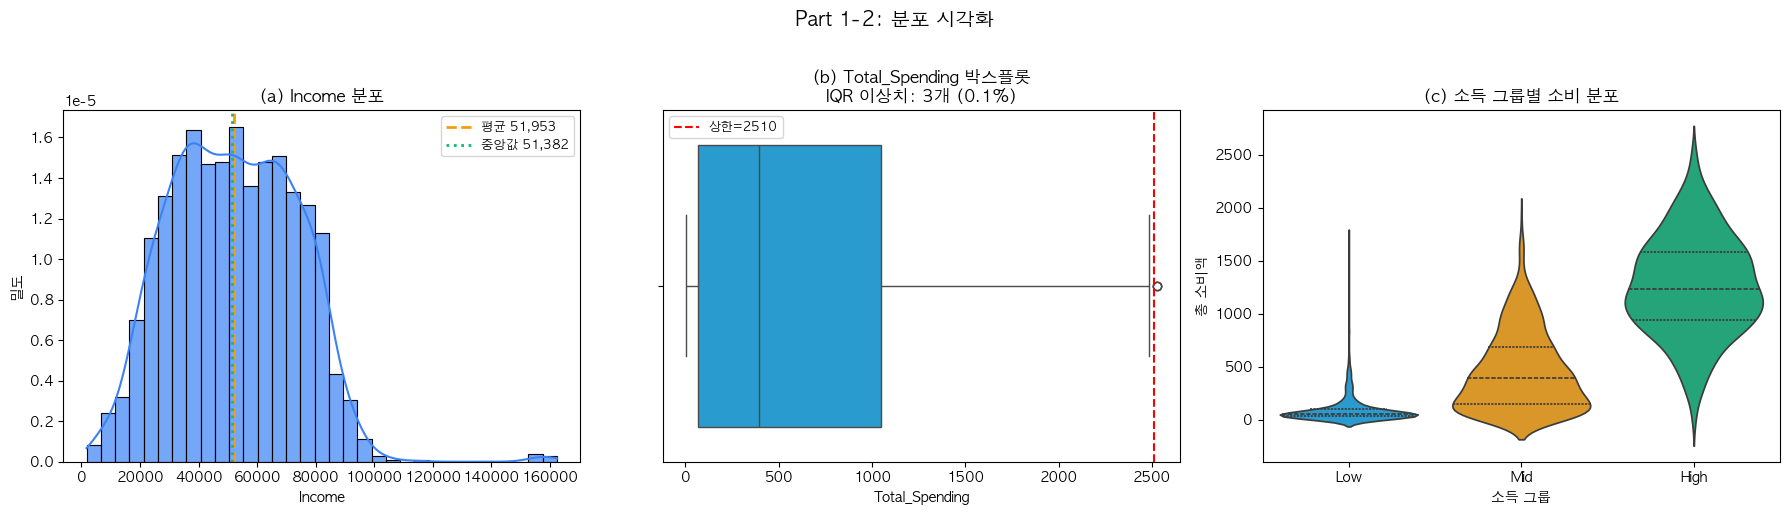

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Income 히스토그램 + KDE
ax = axes[0]
sns.histplot(df['Income'], kde=True, stat='density',
             color=COLORS['blue'], alpha=0.7, ax=ax)
ax.axvline(df['Income'].mean(),   color=COLORS['amber'],   ls='--', lw=2,
           label=f'평균 {df["Income"].mean():,.0f}')
ax.axvline(df['Income'].median(), color=COLORS['emerald'], ls=':',  lw=2,
           label=f'중앙값 {df["Income"].median():,.0f}')
ax.set(xlabel='Income', ylabel='밀도', title='(a) Income 분포')
ax.legend(fontsize=9)

# (b) Total_Spending 수평 박스플롯
ax = axes[1]
sns.boxplot(x=df['Total_Spending'], color=COLORS['sky'], ax=ax)
q1, q3 = df['Total_Spending'].quantile([0.25, 0.75])
iqr    = q3 - q1
upper  = q3 + 1.5 * iqr
lower  = q1 - 1.5 * iqr
n_out  = ((df['Total_Spending'] > upper) | (df['Total_Spending'] < lower)).sum()
ax.axvline(upper, color='red', ls='--', lw=1.5, label=f'상한={upper:.0f}')
ax.set(xlabel='Total_Spending',
       title=f'(b) Total_Spending 박스플롯\nIQR 이상치: {n_out}개 ({n_out/len(df)*100:.1f}%)')
ax.legend(fontsize=9)

# (c) Income_Group별 바이올린 플롯
ax = axes[2]
sns.violinplot(data=df, x='Income_Group', y='Total_Spending',
               order=['Low','Mid','High'], inner='quartile',
               palette=[COLORS['sky'], COLORS['amber'], COLORS['emerald']], ax=ax)
ax.set(xlabel='소득 그룹', ylabel='총 소비액', title='(c) 소득 그룹별 소비 분포')

plt.suptitle('Part 1-2: 분포 시각화', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 1-3. 왜도와 첨도 — 6개 소비 카테고리

=== 왜도·첨도 (초과 첨도 기준) ===


,Wines,Fruits,Meat,Fish,Sweets,Gold
왜도,1.176,2.104,2.085,1.920,2.136,1.885
첨도,0.601,4.070,5.530,3.096,4.372,3.558



해석: 왜도>0 → 오른쪽 꼬리, 첨도>0 → 정규분포보다 뾰족·두꺼운 꼬리


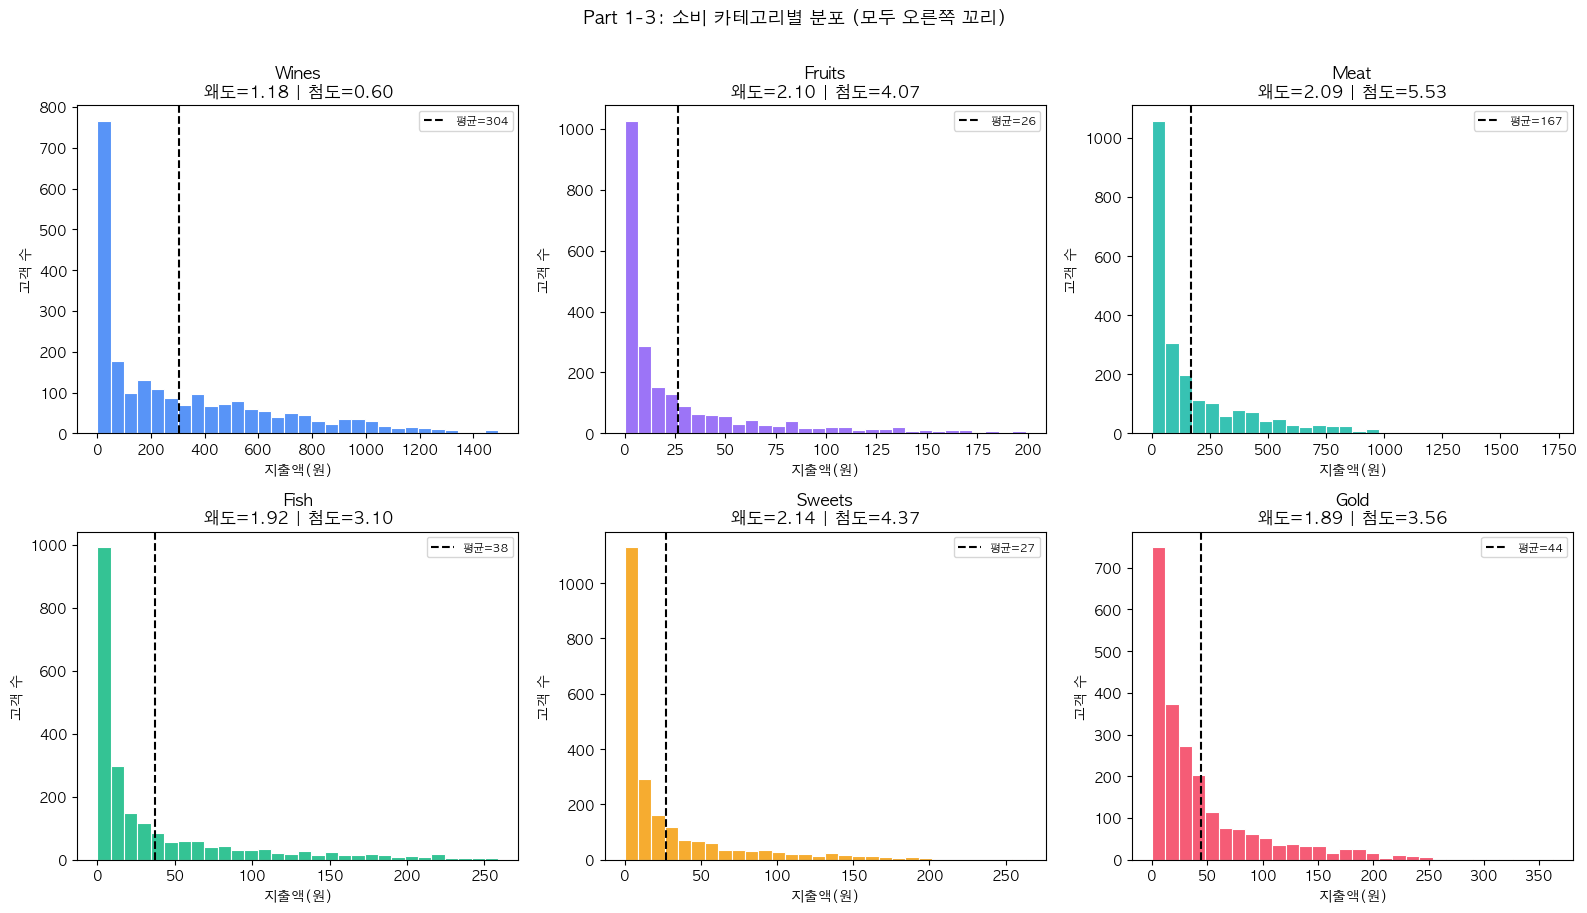

In [7]:
spending_names = ['Wines','Fruits','Meat','Fish','Sweets','Gold']

# 왜도·첨도 테이블
sk_ku = pd.DataFrame({
    name: {'왜도': df[col].skew(), '첨도': df[col].kurt()}
    for col, name in zip(spending_cols, spending_names)
})
print('=== 왜도·첨도 (초과 첨도 기준) ===')
display(sk_ku.round(3))
print('\n해석: 왜도>0 → 오른쪽 꼬리, 첨도>0 → 정규분포보다 뾰족·두꺼운 꼬리')

# 2×3 히스토그램 그리드
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for ax, col, name, color in zip(axes.ravel(), spending_cols, spending_names, hist_colors):
    s, k, m = df[col].skew(), df[col].kurt(), df[col].mean()
    sns.histplot(df[col], bins=30, color=color, alpha=0.85,
                 edgecolor='white', ax=ax)
    ax.axvline(m, color='black', ls='--', lw=1.5, label=f'평균={m:.0f}')
    ax.set(xlabel='지출액(원)', ylabel='고객 수',
           title=f'{name}\n왜도={s:.2f} | 첨도={k:.2f}')
    ax.legend(fontsize=8)

plt.suptitle('Part 1-3: 소비 카테고리별 분포 (모두 오른쪽 꼬리)', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 1-4. 비즈니스 인사이트 정리

In [36]:
cv_spend = df['Total_Spending'].std() / df['Total_Spending'].mean() * 100

print(f"""
----------------------
  Part 1 비즈니스 인사이트
----------------------

[1] 고객 특성 요약
  • 연령  : 평균 {df['Age'].mean():.0f}세 — 주 고객층은 중장년(50~60대)
  • 소득  : 중위 소득 {df['Income'].median():,.0f} — 정규분포에 근접 (평균≈중앙값)
  • 소비  : 평균 {df['Total_Spending'].mean():.0f}, 중앙값 {df['Total_Spending'].median():.0f}
           CV={cv_spend:.0f}% → 고객 간 소비 편차가 매우 큼(양극화)
  • 소비 순위 : 와인 > 육류 > 골드 > 생선 > 과자 > 과일

[2] 핵심 발견
  • Income : 정규분포에 근접, 평균≈중앙값, 왜도 낮음
  • 소비액 : 우편향 분포 — 소수 고소비 VIP + 다수 저소비층 공존
  • 소득 그룹별 소비 격차 뚜렷 (High vs Low 약 16배)
  • 6개 카테고리 모두 왜도>0 — 특정 카테고리 집중 소비 패턴

[3] 후속 검증 가설 (최소 4개)
  H1: 자녀 유무에 따라 총 소비에 유의한 차이가 있다      → Part 3-2
  H2: 동일 고객의 와인·육류 소비 간 차이가 있다          → Part 3-3
  H3: 교육 수준(학력)에 따라 소비 수준이 다르다           → Part 4-2
  H4: 이전 캠페인 반응 경험이 마지막 캠페인 반응에 영향   → Part 5-2
""")


----------------------
  Part 1 비즈니스 인사이트
----------------------

[1] 고객 특성 요약
  • 연령  : 평균 55세 — 주 고객층은 중장년(50~60대)
  • 소득  : 중위 소득 51,382 — 정규분포에 근접 (평균≈중앙값)
  • 소비  : 평균 606, 중앙값 396
           CV=99% → 고객 간 소비 편차가 매우 큼(양극화)
  • 소비 순위 : 와인 > 육류 > 골드 > 생선 > 과자 > 과일

[2] 핵심 발견
  • Income : 정규분포에 근접, 평균≈중앙값, 왜도 낮음
  • 소비액 : 우편향 분포 — 소수 고소비 VIP + 다수 저소비층 공존
  • 소득 그룹별 소비 격차 뚜렷 (High vs Low 약 16배)
  • 6개 카테고리 모두 왜도>0 — 특정 카테고리 집중 소비 패턴

[3] 후속 검증 가설 (최소 4개)
  H1: 자녀 유무에 따라 총 소비에 유의한 차이가 있다      → Part 3-2
  H2: 동일 고객의 와인·육류 소비 간 차이가 있다          → Part 3-3
  H3: 교육 수준(학력)에 따라 소비 수준이 다르다           → Part 4-2
  H4: 이전 캠페인 반응 경험이 마지막 캠페인 반응에 영향   → Part 5-2



---
## Part 2: 확률분포 모델링 — 고객 행동은 어떤 패턴을 따르는가?

### 2-1. 이항분포 — 캠페인 수락 모델링

수락률 p = 0.1494 (14.94%)
B(n=10, p=0.1494) 에서:
  (a) P(X=2)  = 0.2752  (27.52%)
  (b) P(X≥3)  = 0.1782  (17.82%)


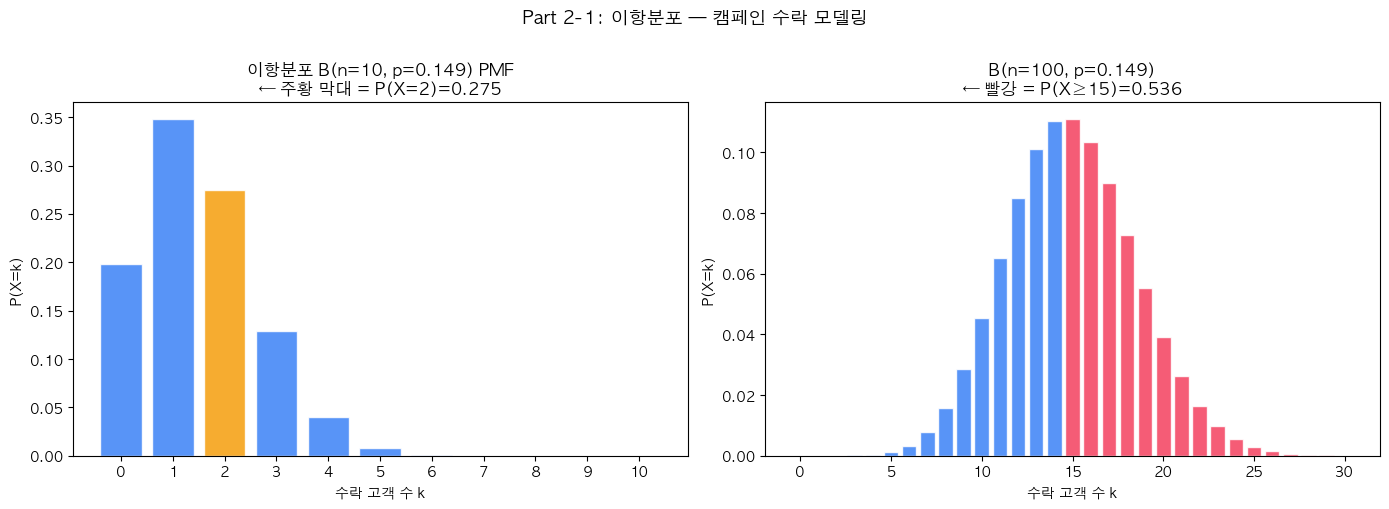


── n=100 확장 결과 ──
  기대 수락자 E(X)         = 14.94명
  P(X ≥ 15)               = 0.5358 (53.58%)
  90% 보장 최소 수락 수    = 10명


In [37]:
# --(a)(b) 확률 계산 --------------------------------------------
n_trial    = 10
p_response = df['Response'].mean()

prob_2      = stats.binom.pmf(2, n_trial, p_response)
prob_3_more = 1 - stats.binom.cdf(2, n_trial, p_response)  # P(X≥3) = 1-P(X≤2)

print(f'수락률 p = {p_response:.4f} ({p_response*100:.2f}%)')
print(f'B(n={n_trial}, p={p_response:.4f}) 에서:')
print(f'  (a) P(X=2)  = {prob_2:.4f}  ({prob_2*100:.2f}%)')
print(f'  (b) P(X≥3)  = {prob_3_more:.4f}  ({prob_3_more*100:.2f}%)')

# --(c) PMF 시각화 --------------------------------------------
x   = np.arange(0, n_trial+1)
pmf = stats.binom.pmf(x, n_trial, p_response)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
bar_colors = [COLORS['amber'] if k==2 else COLORS['blue'] for k in x]
ax.bar(x, pmf, color=bar_colors, edgecolor='white', alpha=0.85)
ax.set(xlabel='수락 고객 수 k', ylabel='P(X=k)', xticks=x,
       title=f'이항분포 B(n={n_trial}, p={p_response:.3f}) PMF\n← 주황 막대 = P(X=2)={prob_2:.3f}')

# -- (d) n=100 확장 ---------------------------------------------
n100           = 100
mean_100       = n100 * p_response
prob_15_more   = 1 - stats.binom.cdf(14, n100, p_response)
min_accept_90  = int(stats.binom.ppf(0.10, n100, p_response))

# n=100 PMF 시각화
ax = axes[1]
x100 = np.arange(0, 31)
pmf100 = stats.binom.pmf(x100, n100, p_response)
bar_colors2 = [COLORS['rose'] if k>=15 else COLORS['blue'] for k in x100]
ax.bar(x100, pmf100, color=bar_colors2, edgecolor='white', alpha=0.85)
ax.set(xlabel='수락 고객 수 k', ylabel='P(X=k)',
       title=f'B(n=100, p={p_response:.3f})\n← 빨강 = P(X≥15)={prob_15_more:.3f}')

plt.suptitle('Part 2-1: 이항분포 — 캠페인 수락 모델링', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f'\n── n=100 확장 결과 ──')
print(f'  기대 수락자 E(X)         = {mean_100:.2f}명')
print(f'  P(X ≥ 15)               = {prob_15_more:.4f} ({prob_15_more*100:.2f}%)')
print(f'  90% 보장 최소 수락 수    = {min_accept_90}명')

### 2-2. 포아송 분포 — 웹사이트 방문 모델링

=== 포아송 적합 평가 ===
  λ̂ (표본 평균) = 5.3189
  표본 분산     = 5.8898
  분산/평균     = 1.1073  (1에 가까울수록 포아송 적합)
  → 포아송 분포 적합 ✓


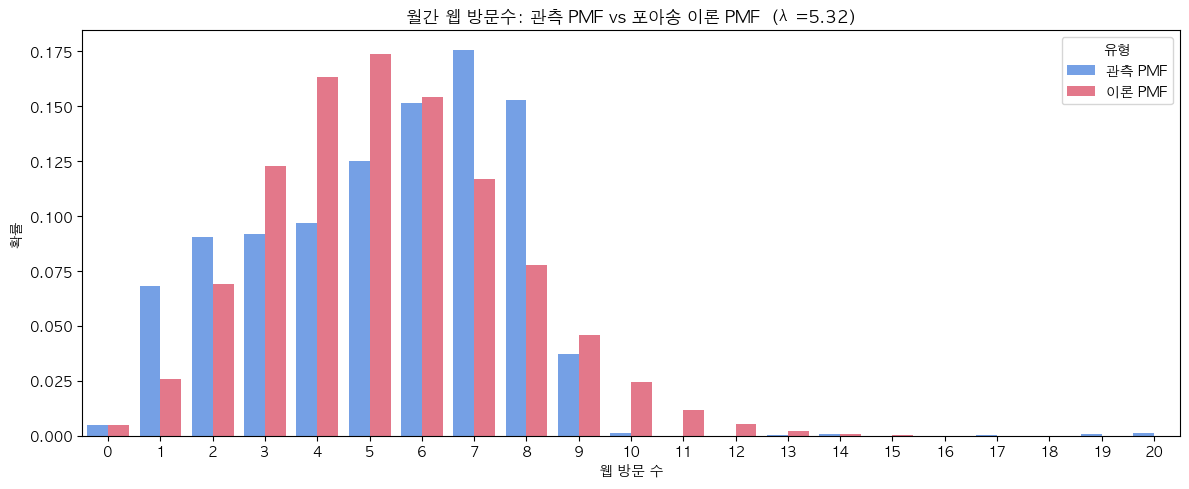


=== 실무 활용 ===
  과다 방문(≥10회) 이론 P(X≥10)  = 0.0449 (4.49%)
  실측 비율 (≥10회)               = 0.0054 (0.54%)
  서버 용량 기준 (이론 95%) → 월 9회
  서버 용량 기준 (실측 95%) → 월 8회
  → 서버는 월 8회 방문까지 처리 가능하도록 용량 설계 권장


In [ ]:
web_visits = df['NumWebVisitsMonth']
lambda_hat = web_visits.mean()
ratio      = web_visits.var() / web_visits.mean()

# --  (a) λ 추정 및 적합 평가 ----------------------------------
print('=== 포아송 적합 평가 ===')
print(f'  λ̂ (표본 평균) = {lambda_hat:.4f}')
print(f'  표본 분산     = {web_visits.var():.4f}')
print(f'  분산/평균     = {ratio:.4f}  (1에 가까울수록 포아송 적합)')
print('  → ' + ('포아송 분포 적합 ✓' if abs(ratio-1) < 0.2
                else f'경미한 과산포 ({ratio:.2f}) — 대체로 포아송 근사 가능'))

#--(b) 실측 vs 이론 PMF 시각화 ----------------------------------
x_pois       = np.arange(0, web_visits.max()+1)
obs_freq     = web_visits.value_counts().sort_index()
obs_pmf_map  = (obs_freq / len(web_visits)).to_dict()
obs_pmf_list = [obs_pmf_map.get(k, 0) for k in x_pois]
theory_pmf   = stats.poisson.pmf(x_pois, lambda_hat)

compare_df = pd.DataFrame({
    '웹 방문 수': np.tile(x_pois, 2),
    '확률':       np.concatenate([obs_pmf_list, theory_pmf]),
    '유형':       ['관측 PMF']*len(x_pois) + ['이론 PMF']*len(x_pois),
})

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=compare_df, x='웹 방문 수', y='확률', hue='유형',
            palette=[COLORS['blue'], COLORS['rose']], alpha=0.8, ax=ax)
ax.set(title=f'월간 웹 방문수: 관측 PMF vs 포아송 이론 PMF  (λ={lambda_hat:.2f})')
plt.tight_layout()
plt.show()

# -- (c) 실무 활용 --------------------------------------------------
prob_10_more    = stats.poisson.sf(9, lambda_hat)
visit_95_theory = int(stats.poisson.ppf(0.95, lambda_hat))
visit_95_obs    = int(web_visits.quantile(0.95))

print(f'\n=== 실무 활용 ===')
print(f'  과다 방문(≥10회) 이론 P(X≥10)  = {prob_10_more:.4f} ({prob_10_more*100:.2f}%)')
print(f'  실측 비율 (≥10회)               = {(web_visits>=10).mean():.4f} ({(web_visits>=10).mean()*100:.2f}%)')
print(f'  서버 용량 기준 (이론 95%) → 월 {visit_95_theory}회')
print(f'  서버 용량 기준 (실측 95%) → 월 {visit_95_obs}회')
print(f'  → 서버는 월 {visit_95_obs}회 방문까지 처리 가능하도록 용량 설계 권장')

### 2-3. 정규분포 — 소득 모델링

μ = 51,953  σ = 21,411

항목                               이론(정규분포)         실측(데이터)
----------------------------------------------------------
P(Income < 30,000)                 0.1526          0.1655
P(Income > 80,000)                 0.0951          0.0962
상위 10% 기준 소득                   79392.5129      79747.5000


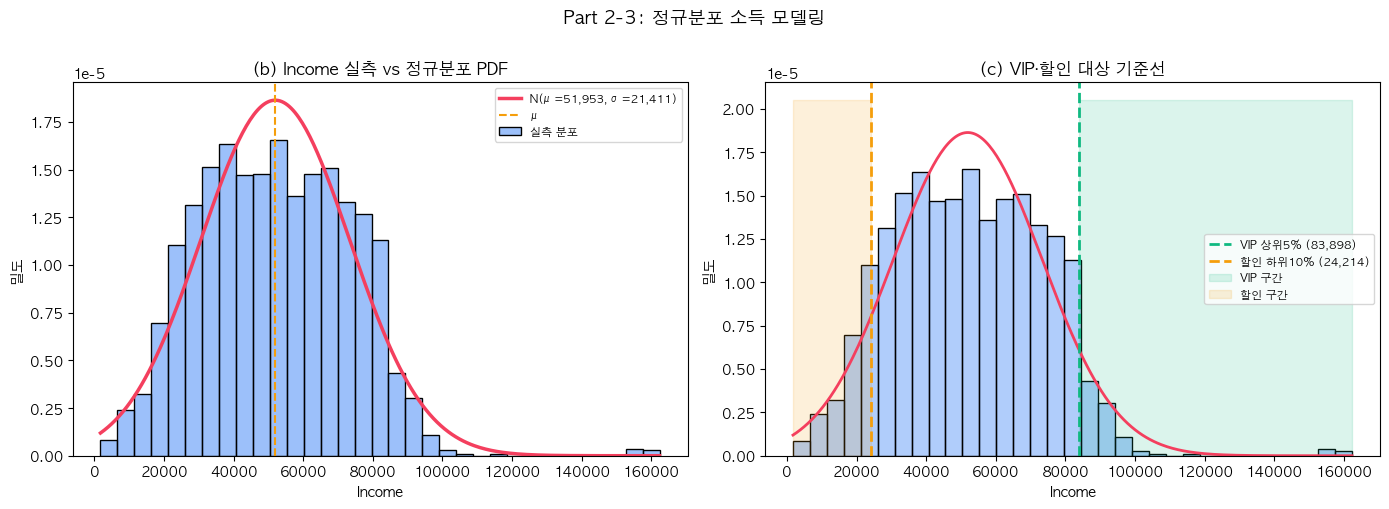


  VIP 기준 (상위 5%)   → 연 소득       83,898 이상
  할인 기준 (하위 10%) → 연 소득       24,214 이하


In [38]:
mu, sigma = df['Income'].mean(), df['Income'].std()

#-- (a) 이론 확률 vs 실측 비율 비교 -------------------------------
print(f'μ = {mu:,.0f}  σ = {sigma:,.0f}\n')
rows = [
    ('P(Income < 30,000)',  stats.norm.cdf(30000, mu, sigma),   (df['Income'] < 30000).mean()),
    ('P(Income > 80,000)',  1-stats.norm.cdf(80000, mu, sigma), (df['Income'] > 80000).mean()),
    ('상위 10% 기준 소득',  stats.norm.ppf(0.9, mu, sigma),     df['Income'].quantile(0.9)),
]
print(f'{"항목":<25} {"이론(정규분포)":>15} {"실측(데이터)":>15}')
print('-'*58)
for name, theory, obs in rows:
    print(f'{name:<25} {theory:>15.4f} {obs:>15.4f}')

# --(b)(c) 시각화 -----------------------------------------------
vip_obs  = df['Income'].quantile(0.95)
disc_obs = df['Income'].quantile(0.10)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램 + 정규 PDF
ax = axes[0]
sns.histplot(df['Income'], stat='density', color=COLORS['blue'],
             alpha=0.5, ax=ax, label='실측 분포')
x_norm   = np.linspace(df['Income'].min(), df['Income'].max(), 300)
norm_pdf = stats.norm.pdf(x_norm, mu, sigma)
ax.plot(x_norm, norm_pdf, color=COLORS['rose'], lw=2.5,
        label=f'N(μ={mu:,.0f}, σ={sigma:,.0f})')
ax.axvline(mu, color=COLORS['amber'], ls='--', lw=1.5, label='μ')
ax.set(xlabel='Income', ylabel='밀도', title='(b) Income 실측 vs 정규분포 PDF')
ax.legend(fontsize=8)

# VIP·할인 기준선
ax = axes[1]
sns.histplot(df['Income'], stat='density', color=COLORS['blue'],
             alpha=0.4, ax=ax)
ax.plot(x_norm, norm_pdf, color=COLORS['rose'], lw=2)
ax.axvline(vip_obs,  color=COLORS['emerald'], ls='--', lw=2,
           label=f'VIP 상위5% ({vip_obs:,.0f})')
ax.axvline(disc_obs, color=COLORS['amber'],   ls='--', lw=2,
           label=f'할인 하위10% ({disc_obs:,.0f})')
ax.fill_betweenx([0, norm_pdf.max()*1.1],
                 vip_obs, df['Income'].max(),
                 alpha=0.15, color=COLORS['emerald'], label='VIP 구간')
ax.fill_betweenx([0, norm_pdf.max()*1.1],
                 df['Income'].min(), disc_obs,
                 alpha=0.15, color=COLORS['amber'], label='할인 구간')
ax.set(xlabel='Income', ylabel='밀도', title='(c) VIP·할인 대상 기준선')
ax.legend(fontsize=8)

plt.suptitle('Part 2-3: 정규분포 소득 모델링', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f'\n  VIP 기준 (상위 5%)   → 연 소득 {vip_obs:>12,.0f} 이상')
print(f'  할인 기준 (하위 10%) → 연 소득 {disc_obs:>12,.0f} 이하')

---
## Part 3: 추정과 가설검정

### 3-1. 신뢰구간 추정
`CI = x̄ ± t(α/2, n-1) × SE`

=== (a) Total_Spending 평균의 신뢰구간 ===
n=2236, 표본평균=605.99, SE=12.7281

    신뢰수준           하한           상한       구간 폭
----------------------------------------------
90%           585.04       626.93      41.89
95%           581.03       630.95      49.92
99%           573.17       638.80      65.63

=== (b) Income_Group별 95% CI ===
   Low: n=746, 평균=95.7, 95% CI=[86.7, 104.6]
   Mid: n=745, 평균=457.9, 95% CI=[431.5, 484.4]
  High: n=745, 평균=1265.0, 95% CI=[1231.4, 1298.7]


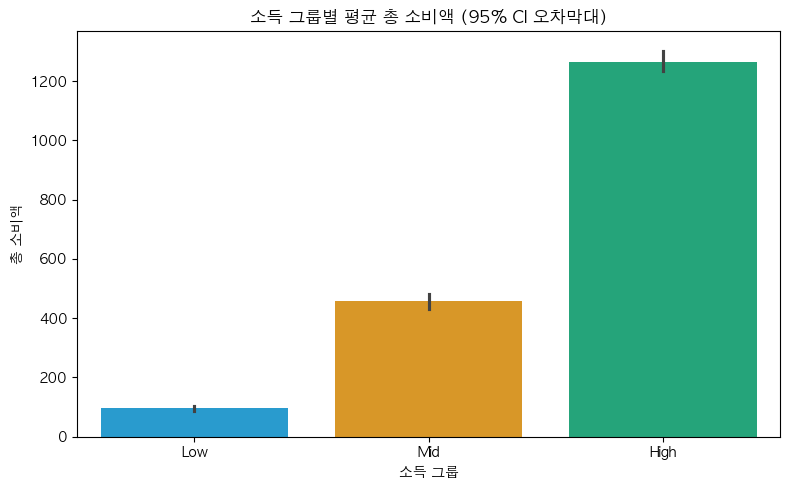

In [39]:
data    = df['Total_Spending']
n       = len(data)
mean_sp = data.mean()
se_sp   = data.std(ddof=1) / np.sqrt(n)

# --(a) 90·95·99% 신뢰구간 ----------------------------------
print('=== (a) Total_Spending 평균의 신뢰구간 ===')
print(f'n={n}, 표본평균={mean_sp:.2f}, SE={se_sp:.4f}\n')
print(f'{"신뢰수준":>8} {"하한":>12} {"상한":>12} {"구간 폭":>10}')
print('-'*46)
for conf in [0.90, 0.95, 0.99]:
    a      = 1 - conf
    t_crit = stats.t.ppf(1 - a/2, df=n-1)
    margin = t_crit * se_sp
    print(f'{conf*100:.0f}%     {mean_sp-margin:>12.2f} {mean_sp+margin:>12.2f} {margin*2:>10.2f}')

# -- (b) Income_Group별 95% CI 오차막대 ---------------------
print('\n=== (b) Income_Group별 95% CI ===')
groups = ['Low','Mid','High']
ci_data = []
for g in groups:
    gdata = df[df['Income_Group']==g]['Total_Spending']
    gn, gm, gse = len(gdata), gdata.mean(), gdata.std(ddof=1)/np.sqrt(len(gdata))
    t_c = stats.t.ppf(0.975, df=gn-1)
    ci_low, ci_high = gm - t_c*gse, gm + t_c*gse
    ci_data.append({'그룹':g, 'n':gn, '평균':gm, 'CI_low':ci_low, 'CI_high':ci_high})
    print(f'  {g:>4}: n={gn}, 평균={gm:.1f}, 95% CI=[{ci_low:.1f}, {ci_high:.1f}]')

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=df, x='Income_Group', y='Total_Spending',
            order=groups, errorbar=('ci', 95),
            palette=[COLORS['sky'], COLORS['amber'], COLORS['emerald']], ax=ax)
ax.set(xlabel='소득 그룹', ylabel='총 소비액',
       title='소득 그룹별 평균 총 소비액 (95% CI 오차막대)')
plt.tight_layout()
plt.show()

### 3-2. 독립표본 t-검정 (Welch's) — 자녀 유무별 소비 차이

- **H₀**: μ_무자녀 = μ_유자녀  
- **H₁**: μ_무자녀 ≠ μ_유자녀  
- Cohen's d 기준: <0.5 작은 / 0.5~0.8 중간 / >0.8 큰

=== Welch's 독립표본 t-검정: 자녀 유무별 총 소비 ===
  무자녀 (n= 637): 평균=1,104.9, std=644.8
  유자녀 (n=1599): 평균=407.2, std=449.9

  t-통계량 = 24.9889
  p-value  = 6.3212e-105
  Cohen's d = 1.3599

  판정(α=0.05): p=6.32e-105 < 0.05 → H₀ 기각 ✓
  효과 크기: |d|=1.360 → 큰 효과
  해석: 무자녀 고객이 유자녀 고객보다 평균 698원 더 소비


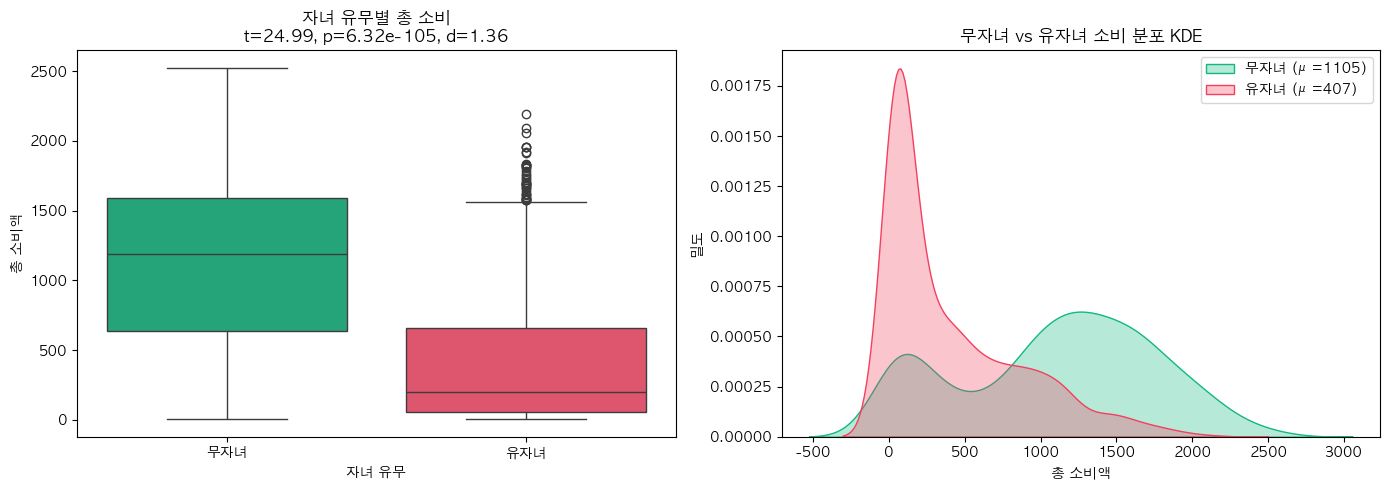

In [13]:
no_child  = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)

# Cohen's d (pooled)
n1, n2   = len(no_child), len(yes_child)
pooled_s = np.sqrt(((n1-1)*no_child.var() + (n2-1)*yes_child.var()) / (n1+n2-2))
cohens_d = (no_child.mean() - yes_child.mean()) / pooled_s

print('=== Welch\'s 독립표본 t-검정: 자녀 유무별 총 소비 ===')
print(f'  무자녀 (n={n1:4d}): 평균={no_child.mean():,.1f}, std={no_child.std():,.1f}')
print(f'  유자녀 (n={n2:4d}): 평균={yes_child.mean():,.1f}, std={yes_child.std():,.1f}')
print(f'\n  t-통계량 = {t_stat:.4f}')
print(f'  p-value  = {p_value:.4e}')
print(f'  Cohen\'s d = {cohens_d:.4f}')

result_str = 'H₀ 기각 ✓' if p_value < 0.05 else 'H₀ 채택'
effect_str = '작은' if abs(cohens_d) < 0.5 else ('중간' if abs(cohens_d) < 0.8 else '큰')
print(f'\n  판정(α=0.05): p={p_value:.2e} < 0.05 → {result_str}')
print(f'  효과 크기: |d|={abs(cohens_d):.3f} → {effect_str} 효과')
print(f'  해석: 무자녀 고객이 유자녀 고객보다 평균 {no_child.mean()-yes_child.mean():.0f}원 더 소비')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
sns.boxplot(data=df, x='Has_Children', y='Total_Spending',
            palette=[COLORS['emerald'], COLORS['rose']], ax=ax)
ax.set(xlabel='자녀 유무', ylabel='총 소비액',
       title=f'자녀 유무별 총 소비\nt={t_stat:.2f}, p={p_value:.2e}, d={cohens_d:.2f}',
       xticklabels=['무자녀', '유자녀'])

ax = axes[1]
for grp, col, label in [(no_child, COLORS['emerald'], '무자녀'), (yes_child, COLORS['rose'], '유자녀')]:
    sns.kdeplot(grp, ax=ax, color=col, fill=True, alpha=0.3, label=f'{label} (μ={grp.mean():.0f})')
ax.set(xlabel='총 소비액', ylabel='밀도', title='무자녀 vs 유자녀 소비 분포 KDE')
ax.legend()

plt.tight_layout()
plt.show()

### 3-3. 대응표본 t-검정 — 와인 vs 육류 소비

- **H₀**: μ_Wine = μ_Meat (차이=0)  
- **H₁**: μ_Wine ≠ μ_Meat

=== 대응표본 t-검정: 와인 vs 육류 소비 ===
  와인 평균 = 304.13
  육류 평균 = 166.98
  차이(W-M) 평균=137.14, std=280.82

  t-통계량 = 23.0929
  p-value  = 5.3919e-106
  Cohen's d = 0.4884

  판정: p < 0.05 → H₀ 기각 ✓ — 와인·육류 소비 간 유의한 차이 있음
  효과 크기: |d|=0.488 → 작은 효과


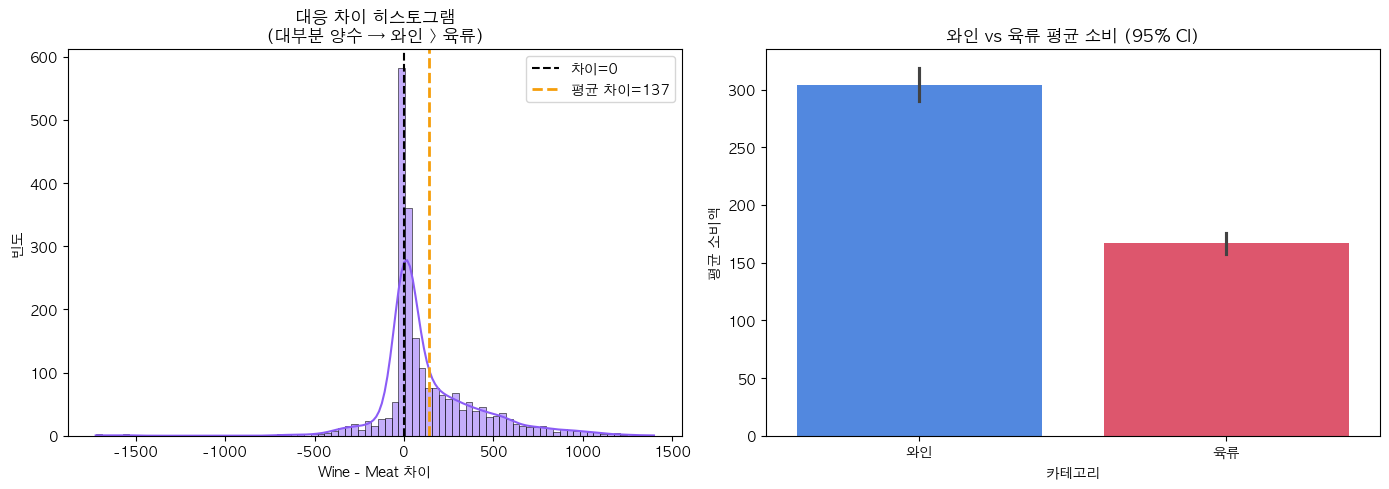

In [14]:
wines = df['MntWines']
meat  = df['MntMeatProducts']
diff  = wines - meat

t_pair, p_pair = stats.ttest_rel(wines, meat)
d_pair         = diff.mean() / diff.std(ddof=1)

print('=== 대응표본 t-검정: 와인 vs 육류 소비 ===')
print(f'  와인 평균 = {wines.mean():.2f}')
print(f'  육류 평균 = {meat.mean():.2f}')
print(f'  차이(W-M) 평균={diff.mean():.2f}, std={diff.std():.2f}')
print(f'\n  t-통계량 = {t_pair:.4f}')
print(f'  p-value  = {p_pair:.4e}')
print(f'  Cohen\'s d = {d_pair:.4f}')

effect_str = '작은' if abs(d_pair) < 0.5 else ('중간' if abs(d_pair) < 0.8 else '큰')
print(f'\n  판정: p < 0.05 → H₀ 기각 ✓ — 와인·육류 소비 간 유의한 차이 있음')
print(f'  효과 크기: |d|={abs(d_pair):.3f} → {effect_str} 효과')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
sns.histplot(diff, kde=True, color=COLORS['violet'], ax=ax)
ax.axvline(0,          color='black',        ls='--', lw=1.5, label='차이=0')
ax.axvline(diff.mean(),color=COLORS['amber'], ls='--', lw=2,
           label=f'평균 차이={diff.mean():.0f}')
ax.set(xlabel='Wine - Meat 차이', ylabel='빈도',
       title=f'대응 차이 히스토그램\n(대부분 양수 → 와인 > 육류)')
ax.legend()

ax = axes[1]
melt_df = df[['MntWines','MntMeatProducts']].melt(var_name='카테고리', value_name='소비액')
sns.barplot(data=melt_df, x='카테고리', y='소비액',
            errorbar=('ci', 95), palette=[COLORS['blue'], COLORS['rose']], ax=ax)
ax.set(xlabel='카테고리', ylabel='평균 소비액',
       title='와인 vs 육류 평균 소비 (95% CI)',
       xticklabels=['와인', '육류'])

plt.tight_layout()
plt.show()

---
## Part 4: 고급 검정 — 교육·결혼·캠페인 반응의 관계는?

### 4-1. 정규성 + 등분산 검정

=== Shapiro-Wilk 정규성 검정 ===
            그룹      n        W-통계량      p-value        정규성
----------------------------------------------------------
 Undergraduate    255       0.7605       0.0000     기각(위반)
      Graduate   1126       0.8743       0.0000     기각(위반)
  Postgraduate    855       0.8765       0.0000     기각(위반)

→ 표본 크기 n≥30이면 CLT에 의해 ANOVA 강건하게 적용 가능
→ 단, 등분산 위반은 CLT로 해결 불가 — 별도 검증 필요

=== Levene 등분산 검정 ===
  W=13.2893, p=0.0000
  → p < 0.05: 등분산 가정 위반 ✗ → Welch's ANOVA 사용


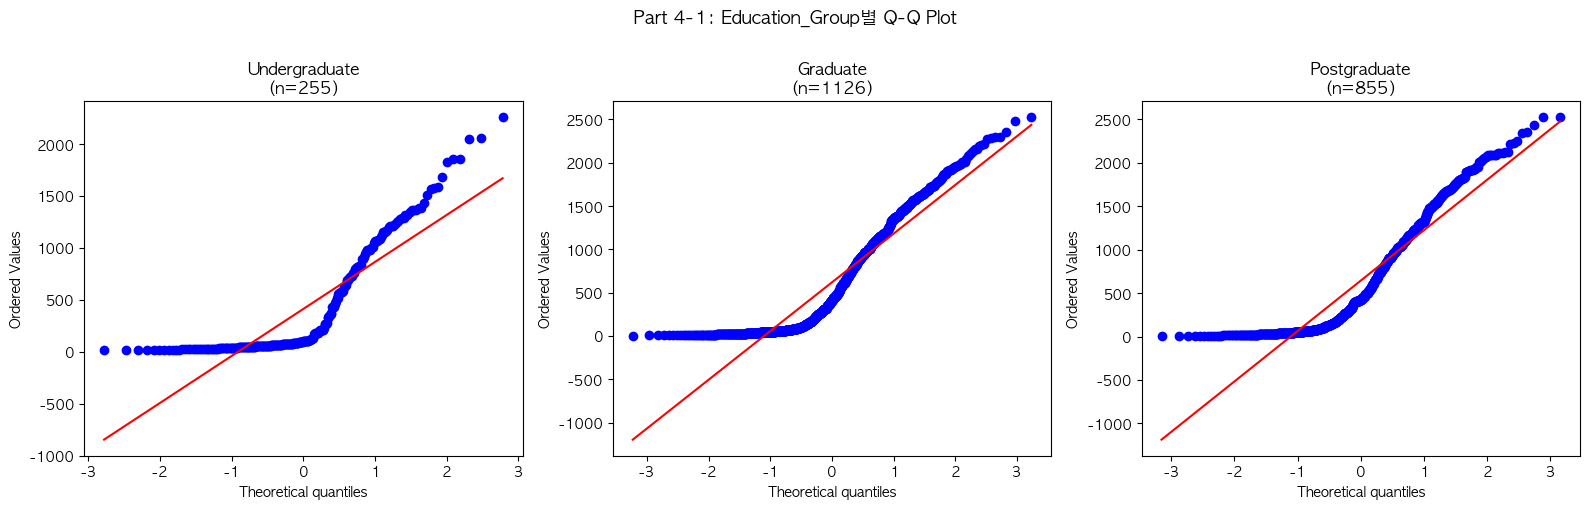

In [40]:
edu_groups    = ['Undergraduate', 'Graduate', 'Postgraduate']
group_arrays  = [df[df['Education_Group']==g]['Total_Spending'].values for g in edu_groups]

# --(a) Shapiro-Wilk + Levene ----------------------------------------------
print('=== Shapiro-Wilk 정규성 검정 ===')
print(f'{"그룹":>14} {"n":>6} {"W-통계량":>12} {"p-value":>12} {"정규성":>10}')
print('-'*58)
for g, arr in zip(edu_groups, group_arrays):
    stat, p = stats.shapiro(arr)
    flag    = '만족' if p >= 0.05 else '기각(위반)'
    print(f'{g:>14} {len(arr):>6} {stat:>12.4f} {p:>12.4f} {flag:>10}')

print('\n→ 표본 크기 n≥30이면 CLT에 의해 ANOVA 강건하게 적용 가능')
print('→ 단, 등분산 위반은 CLT로 해결 불가 — 별도 검증 필요')

lev_stat, lev_p = stats.levene(*group_arrays)
print(f'\n=== Levene 등분산 검정 ===')
print(f'  W={lev_stat:.4f}, p={lev_p:.4f}')
if lev_p < 0.05:
    print('  → p < 0.05: 등분산 가정 위반 ✗ → Welch\'s ANOVA 사용')
else:
    print('  → p ≥ 0.05: 등분산 만족 ✓ → One-way ANOVA 사용')

# ── (b) Q-Q Plot ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for g, arr, ax in zip(edu_groups, group_arrays, axes):
    stats.probplot(arr, dist='norm', plot=ax)
    ax.set_title(f'{g}\n(n={len(arr)})')

plt.suptitle('Part 4-1: Education_Group별 Q-Q Plot', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 4-2. ANOVA + 사후검정

등분산 위반 → **Welch's ANOVA + Tukey HSD (수동 구현)**  
비모수 병행: **Kruskal-Wallis**

In [21]:
# ── (a) Welch's ANOVA (직접 구현) ────────────────────────────
def welch_anova(*groups):
    """Welch's one-way ANOVA — 등분산 가정 불필요"""
    k     = len(groups)
    ns    = np.array([len(g) for g in groups])
    means = np.array([g.mean() for g in groups])
    vars_ = np.array([g.var(ddof=1) for g in groups])
    ws    = ns / vars_
    W     = ws.sum()
    grand = (ws * means).sum() / W
    F_num = sum(ws[i]*(means[i]-grand)**2 for i in range(k)) / (k-1)
    lambda_ = sum(((1 - ws[i]/W)**2) / (ns[i]-1) for i in range(k))
    F_den  = 1 + 2*(k-2)/(k**2-1) * lambda_
    F      = F_num / F_den
    df2    = (k**2 - 1) / (3 * lambda_)
    p      = 1 - stats.f.cdf(F, k-1, df2)
    return F, p, df2

F_welch, p_welch, df2_welch = welch_anova(*group_arrays)
H_kw, p_kw = stats.kruskal(*group_arrays)

print('=== Welch\'s ANOVA ===')
print(f'  F={F_welch:.4f}, df2≈{df2_welch:.1f}, p={p_welch:.4e}')
print('  → p < 0.05: 교육 수준별 소비에 유의한 차이 있음 ✓' if p_welch < 0.05 else '  → H₀ 채택')

print(f'\n=== Kruskal-Wallis (비모수 병행) ===')
print(f'  H={H_kw:.4f}, p={p_kw:.4e}')
print('  → 두 검정 모두 유의 — 결과 일관성 확인 ✓')

# ── (b) η², ω² 효과 크기 ────────────────────────────────────
f_oneway, _ = stats.f_oneway(*group_arrays)
k       = len(group_arrays)
N_total = sum(len(g) for g in group_arrays)
grand_mean = np.concatenate(group_arrays).mean()
SS_between = sum(len(g)*(g.mean()-grand_mean)**2 for g in group_arrays)
SS_within  = sum(((g - g.mean())**2).sum() for g in group_arrays)
SS_total   = SS_between + SS_within
MS_within  = SS_within / (N_total - k)
eta_sq     = SS_between / SS_total
omega_sq   = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)

print(f'\n=== 효과 크기 ===')
print(f'  η² (eta-squared)   = {eta_sq:.4f}')
print(f'  ω² (omega-squared) = {omega_sq:.4f}')
e_label = '작은' if eta_sq < 0.06 else ('중간' if eta_sq < 0.14 else '큰')
print(f'  → {e_label} 효과 크기  (기준: 0.01 작은, 0.06 중간, 0.14 큰)')

# ── (c) 사후검정: Tukey HSD (수동 구현) ─────────────────────
from scipy.stats import studentized_range

print('\n=== 사후검정: Tukey HSD (쌍별 비교) ===')
print(f'{"쌍":>35} {"평균 차":>10} {"p-value":>10} {"유의":>6} {"Cohen d":>9}')
print('-'*74)

for (i,j) in combinations(range(k), 2):
    gi, gj   = group_arrays[i], group_arrays[j]
    ni, nj   = len(gi), len(gj)
    mi, mj   = gi.mean(), gj.mean()
    # Tukey HSD t
    se_ij    = np.sqrt(MS_within * (1/ni + 1/nj))
    q_stat   = abs(mi - mj) / se_ij
    # studentized range 분포로 p 계산
    try:
        p_tukey = 1 - studentized_range.cdf(q_stat, k, N_total-k)
    except Exception:
        p_tukey = stats.t.sf(q_stat/np.sqrt(2), df=N_total-k) * 2
    # Cohen's d
    pool_d   = np.sqrt(((ni-1)*gi.var() + (nj-1)*gj.var()) / (ni+nj-2))
    d_ij     = (mi - mj) / pool_d
    sig      = '✓' if p_tukey < 0.05 else ''
    pair_str = f'{edu_groups[i]} vs {edu_groups[j]}'
    print(f'{pair_str:>35} {mi-mj:>10.1f} {p_tukey:>10.4f} {sig:>6} {d_ij:>9.3f}')

=== Welch's ANOVA ===
  F=19.8174, df2≈751.7, p=4.0987e-09
  → p < 0.05: 교육 수준별 소비에 유의한 차이 있음 ✓

=== Kruskal-Wallis (비모수 병행) ===
  H=36.6133, p=1.1208e-08
  → 두 검정 모두 유의 — 결과 일관성 확인 ✓

=== 효과 크기 ===
  η² (eta-squared)   = 0.0137
  ω² (omega-squared) = 0.0128
  → 작은 효과 크기  (기준: 0.01 작은, 0.06 중간, 0.14 큰)

=== 사후검정: Tukey HSD (쌍별 비교) ===
                                  쌍       평균 차    p-value     유의   Cohen d
--------------------------------------------------------------------------
          Undergraduate vs Graduate     -208.1     0.0011      ✓    -0.356
      Undergraduate vs Postgraduate     -232.5     0.0004      ✓    -0.390
           Graduate vs Postgraduate      -24.4     0.8003           -0.040


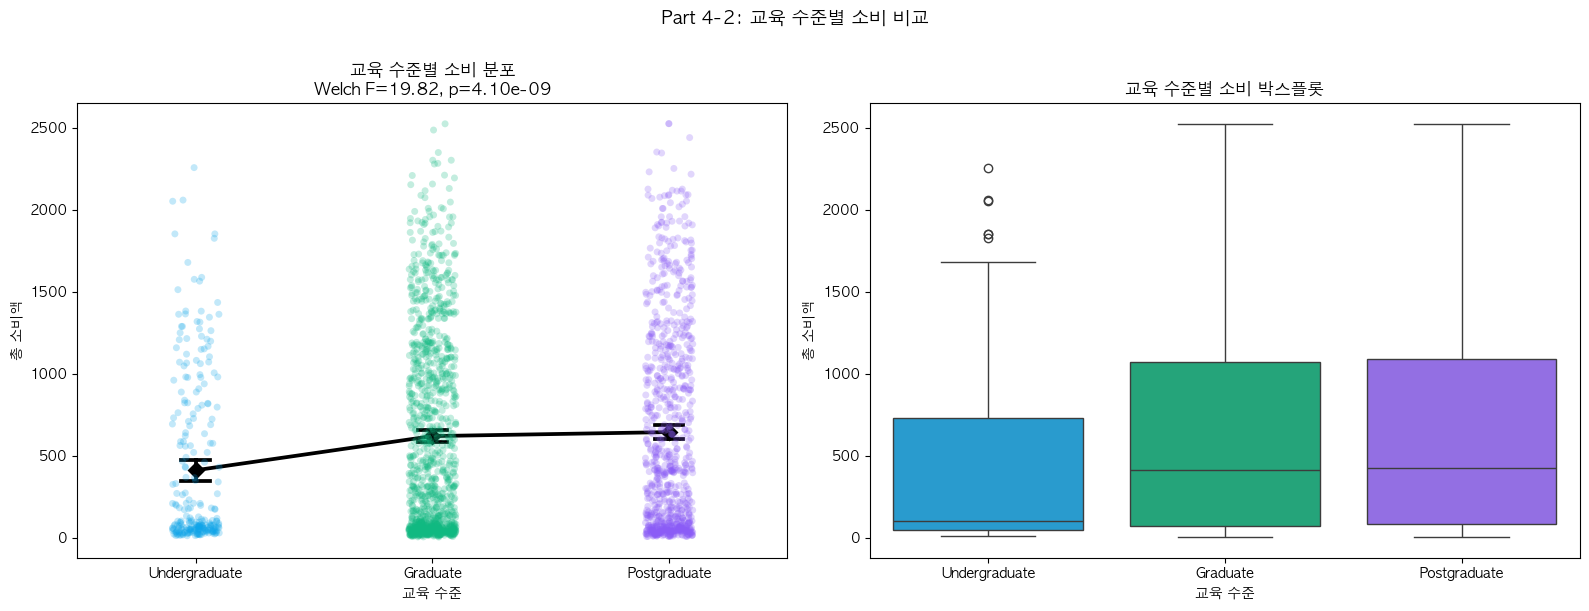

In [22]:
# (d) 시각화 — 산점도 + 평균 다이아몬드
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
palette_edu = [COLORS['sky'], COLORS['emerald'], COLORS['violet']]
sns.stripplot(data=df, x='Education_Group', y='Total_Spending',
              order=edu_groups, alpha=0.25, jitter=True,
              palette=palette_edu, ax=ax)
sns.pointplot(data=df, x='Education_Group', y='Total_Spending',
              order=edu_groups, markers='D', color='black',
              errorbar=('ci',95), capsize=0.12, ax=ax)
ax.set(xlabel='교육 수준', ylabel='총 소비액',
       title=f'교육 수준별 소비 분포\nWelch F={F_welch:.2f}, p={p_welch:.2e}')

ax = axes[1]
sns.boxplot(data=df, x='Education_Group', y='Total_Spending',
            order=edu_groups, palette=palette_edu, ax=ax)
ax.set(xlabel='교육 수준', ylabel='총 소비액', title='교육 수준별 소비 박스플롯')

plt.suptitle('Part 4-2: 교육 수준별 소비 비교', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 4-3. 카이제곱 독립성 검정 — 결혼 상태 × 캠페인 반응

- **H₀**: Marital_Group ⊥ Campaign_Response (독립)  
- **H₁**: 두 변수는 독립이 아니다  
- φ = √(χ²/n) 효과크기: 0.1 작은 / 0.3 중간 / 0.5 큰

=== 교차표 ===


Campaign_Response,False,True
Marital_Group,,
Single,547,247
Together,1081,361



=== 카이제곱 검정 ===
  χ²=9.2368, p=0.0024, dof=1
  기대빈도<5인 셀: 0.0%  (Cochran 기준 20% 이하 → 카이제곱 사용 가능)

  φ = 0.0643 → 작은 효과 크기
  → p < 0.05: H₀ 기각 — 결혼 상태와 캠페인 반응은 독립이 아님

  오즈비 OR = 1.3522  95% CI=[1.1162, 1.6380]
  싱글 반응률  = 0.3111
  기혼 반응률  = 0.2503
  → 싱글 고객이 기혼 고객 대비 캠페인 반응 오즈가 1.35배


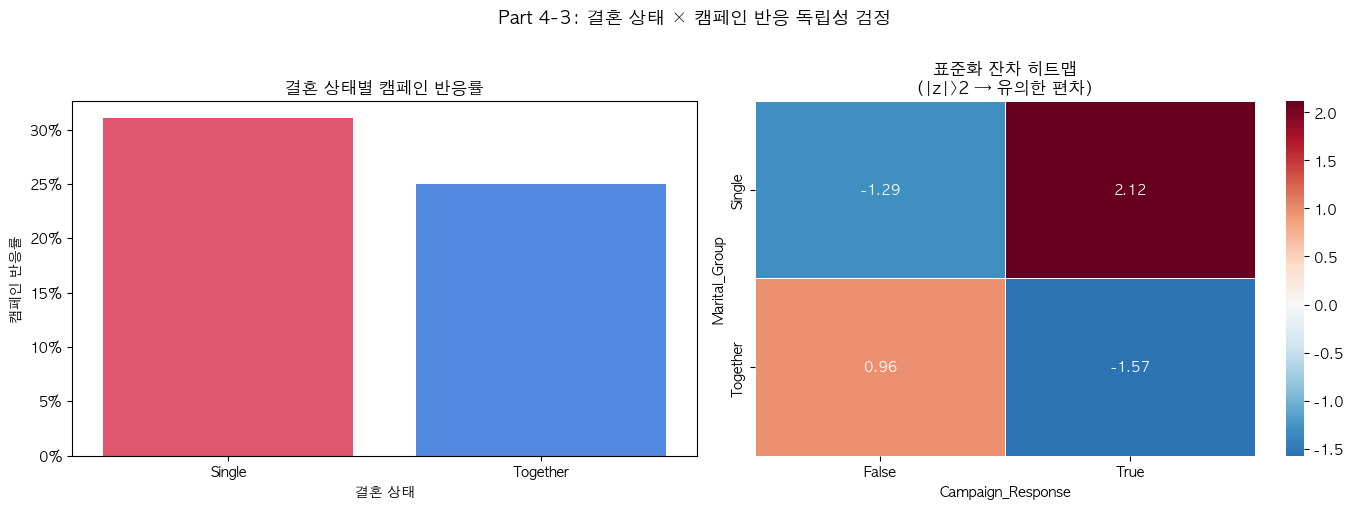

In [23]:
crosstab = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])
print('=== 교차표 ===')
display(crosstab)

chi2_val, p_chi, dof, expected = stats.chi2_contingency(crosstab)
n_total  = crosstab.sum().sum()

# Cochran 규칙
pct_below5 = (expected < 5).mean() * 100
print(f'\n=== 카이제곱 검정 ===')
print(f'  χ²={chi2_val:.4f}, p={p_chi:.4f}, dof={dof}')
print(f'  기대빈도<5인 셀: {pct_below5:.1f}%  (Cochran 기준 20% 이하 → 카이제곱 사용 가능)')

# φ 효과크기
phi = np.sqrt(chi2_val / n_total)
phi_label = '작은' if phi < 0.3 else ('중간' if phi < 0.5 else '큰')
print(f'\n  φ = {phi:.4f} → {phi_label} 효과 크기')
print('  → p < 0.05: H₀ 기각 — 결혼 상태와 캠페인 반응은 독립이 아님' if p_chi < 0.05
      else '  → H₀ 채택')

# 오즈비 + 95% CI
a = crosstab.loc['Single',   True]
b = crosstab.loc['Single',   False]
c = crosstab.loc['Together', True]
d_ct = crosstab.loc['Together', False]
OR = (a*d_ct) / (b*c)
SE_log = np.sqrt(1/a + 1/b + 1/c + 1/d_ct)
ci_or_low  = np.exp(np.log(OR) - 1.96*SE_log)
ci_or_high = np.exp(np.log(OR) + 1.96*SE_log)

print(f'\n  오즈비 OR = {OR:.4f}  95% CI=[{ci_or_low:.4f}, {ci_or_high:.4f}]')
print(f'  싱글 반응률  = {df[df["Marital_Group"]=="Single"]["Campaign_Response"].mean():.4f}')
print(f'  기혼 반응률  = {df[df["Marital_Group"]=="Together"]["Campaign_Response"].mean():.4f}')
print(f'  → 싱글 고객이 기혼 고객 대비 캠페인 반응 오즈가 {OR:.2f}배')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
rate_by_marital = df.groupby('Marital_Group')['Campaign_Response'].mean().reset_index()
sns.barplot(data=rate_by_marital, x='Marital_Group', y='Campaign_Response',
            palette=[COLORS['rose'], COLORS['blue']], ax=ax)
ax.set(xlabel='결혼 상태', ylabel='캠페인 반응률', title='결혼 상태별 캠페인 반응률')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f'{y:.0%}'))

ax = axes[1]
residuals = (crosstab - expected) / np.sqrt(expected)
sns.heatmap(residuals, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, linewidths=0.5, ax=ax)
ax.set_title('표준화 잔차 히트맵\n(|z|>2 → 유의한 편차)')

plt.suptitle('Part 4-3: 결혼 상태 × 캠페인 반응 독립성 검정', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 4-4. 카이제곱 적합도 검정 — 구매 채널 균등 분포

- **H₀**: Web : Catalog : Store = 1/3 : 1/3 : 1/3  
- **H₁**: 구매 채널 비율이 균등하지 않다

=== 채널별 총 구매 현황 ===
       Web: 관측= 9,140  기대= 9,351  비율=0.326
   Catalog: 관측= 5,955  기대= 9,351  비율=0.212
     Store: 관측=12,959  기대= 9,351  비율=0.462

=== 카이제곱 적합도 검정 ===
  χ²=2630.1063, p=0.0000e+00
  → p < 0.05: H₀ 기각 — 채널별 구매 비율이 균등하지 않음 ✓

  Cohen's w = 0.3062 → 중간 효과 크기
  해석: 스토어(46.2%) > 웹(32.6%) > 카탈로그(21.2%) 순


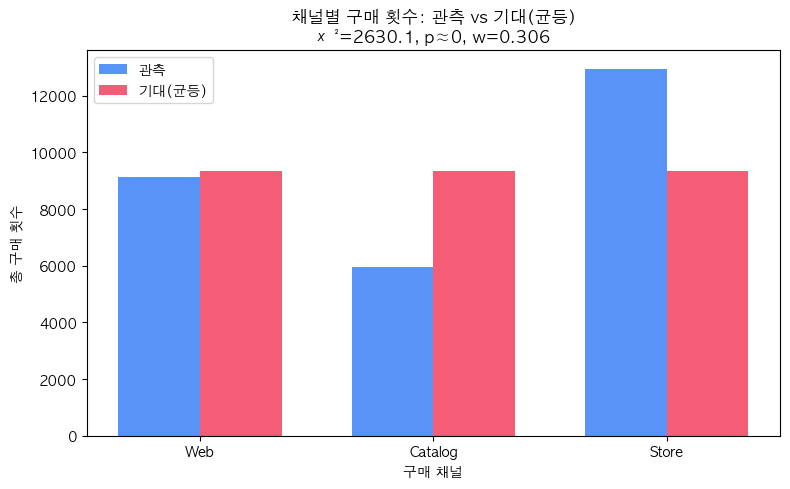

In [24]:
channel_names = ['Web', 'Catalog', 'Store']
observed      = df[purchase_cols].sum().values
expected_gof  = np.full(3, observed.sum() / 3)

chi2_gof, p_gof = stats.chisquare(observed, expected_gof)

print('=== 채널별 총 구매 현황 ===')
for name, obs, exp in zip(channel_names, observed, expected_gof):
    print(f'  {name:>8}: 관측={obs:>6,.0f}  기대={exp:>6,.0f}  비율={obs/observed.sum():.3f}')

print(f'\n=== 카이제곱 적합도 검정 ===')
print(f'  χ²={chi2_gof:.4f}, p={p_gof:.4e}')
print('  → p < 0.05: H₀ 기각 — 채널별 구매 비율이 균등하지 않음 ✓')

# Cohen's w
obs_p     = observed / observed.sum()
exp_p     = expected_gof / expected_gof.sum()
cohens_w  = np.sqrt(np.sum((obs_p - exp_p)**2 / exp_p))
w_label   = '작은' if cohens_w < 0.3 else ('중간' if cohens_w < 0.5 else '큰')
print(f'\n  Cohen\'s w = {cohens_w:.4f} → {w_label} 효과 크기')
print(f'  해석: 스토어({obs_p[2]:.1%}) > 웹({obs_p[0]:.1%}) > 카탈로그({obs_p[1]:.1%}) 순')

# 시각화
fig, ax = plt.subplots(figsize=(8, 5))
x_pos  = np.arange(3)
width  = 0.35
ax.bar(x_pos - width/2, observed,     width=width, color=COLORS['blue'],  label='관측', alpha=0.85)
ax.bar(x_pos + width/2, expected_gof, width=width, color=COLORS['rose'],  label='기대(균등)', alpha=0.85)
ax.set_xticks(x_pos)
ax.set_xticklabels(channel_names)
ax.set(xlabel='구매 채널', ylabel='총 구매 횟수',
       title=f'채널별 구매 횟수: 관측 vs 기대(균등)\nχ²={chi2_gof:.1f}, p≈0, w={cohens_w:.3f}')
ax.legend()
plt.tight_layout()
plt.show()

---
## Part 5: 상관분석 / 비율 비교

### 5-1. 상관분석

변수 쌍                                                 r      p-value     유의
--------------------------------------------------------------------------
Income × Age                                    0.1988   2.2696e-21      ✓
Income × Total_Spending                         0.7894   0.0000e+00      ✓
Income × Total_Purchases                        0.7386   0.0000e+00      ✓
Income × NumWebVisitsMonth                     -0.6464  9.8673e-265      ✓
Income × Recency                                0.0078   7.1137e-01       
Age × Total_Spending                            0.1136   7.1638e-08      ✓
Age × Total_Purchases                           0.1730   1.7463e-16      ✓
Age × NumWebVisitsMonth                        -0.1175   2.5149e-08      ✓
Age × Recency                                   0.0194   3.5927e-01       
Total_Spending × Total_Purchases                0.8211   0.0000e+00      ✓
Total_Spending × NumWebVisitsMonth             -0.4999  1.0727e-141      ✓
Total_Spending × Recency 

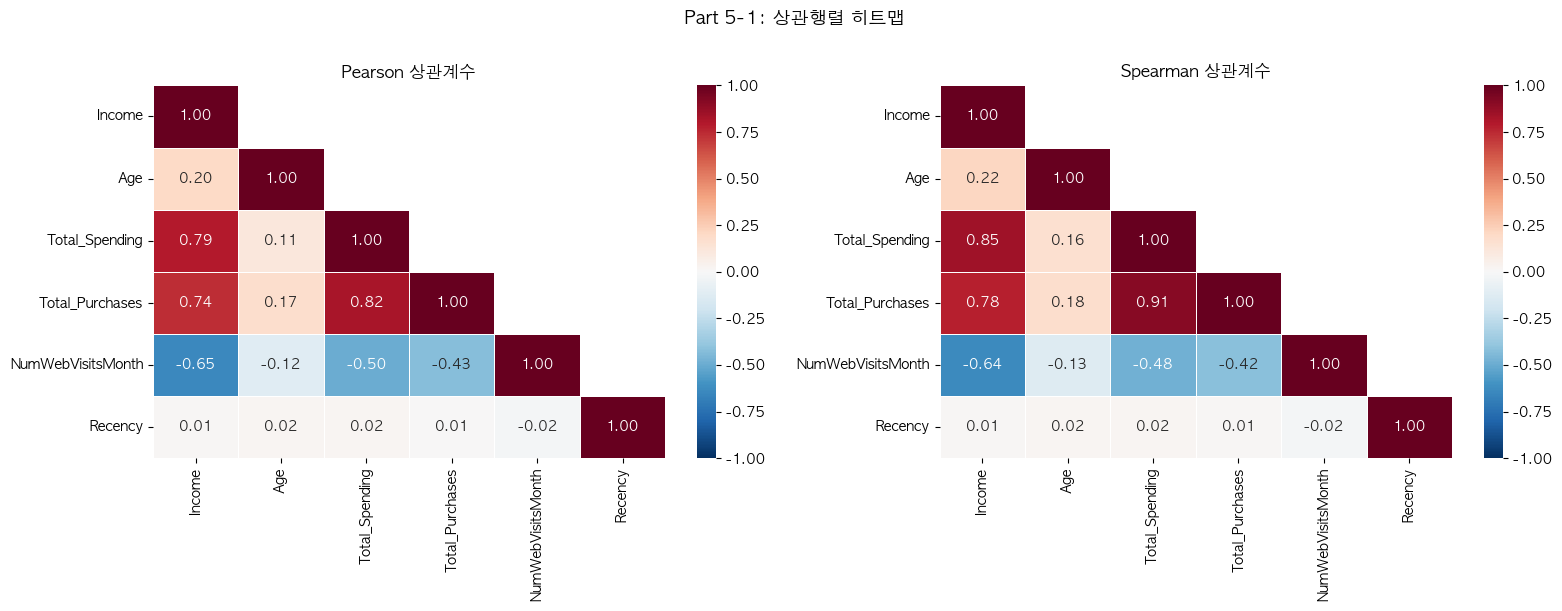

In [25]:
corr_vars = ['Income','Age','Total_Spending','Total_Purchases',
             'NumWebVisitsMonth','Recency']
df_corr   = df[corr_vars]

# ── (a) Pearson / Spearman 상관행렬 ─────────────────────────
pearson_corr  = df_corr.corr(method='pearson')
spearman_corr = df_corr.corr(method='spearman')

# ── (b) 주요 쌍 유의성 검정 ──────────────────────────────────
print(f'{"변수 쌍":<45} {"r":>8} {"p-value":>12} {"유의":>6}')
print('-'*74)
for v1, v2 in combinations(corr_vars, 2):
    r, p = stats.pearsonr(df[v1], df[v2])
    sig  = '✓' if p < 0.05 else ''
    print(f'{v1+" × "+v2:<45} {r:>8.4f} {p:>12.4e} {sig:>6}')

# ── (c) 히트맵 (1×2) ─────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, mat, title in zip(axes,
                           [pearson_corr, spearman_corr],
                           ['Pearson 상관계수', 'Spearman 상관계수']):
    mask = np.triu(np.ones_like(mat, dtype=bool), k=1)
    sns.heatmap(mat, mask=mask, annot=True, fmt='.2f',
                cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                linewidths=0.5, ax=ax)
    ax.set_title(title, fontsize=12)

plt.suptitle('Part 5-1: 상관행렬 히트맵', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

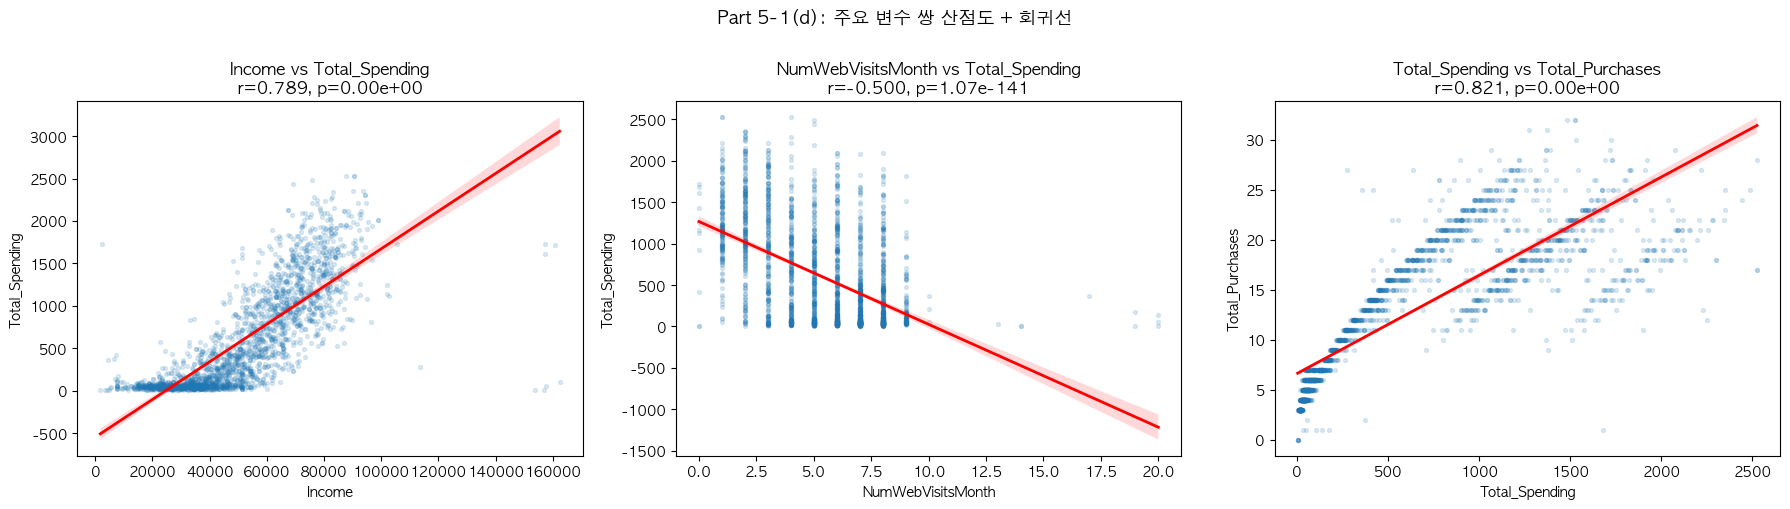

In [26]:
# ── (d) 주요 쌍 산점도 + 회귀선 ─────────────────────────────
pairs = [
    ('Income',            'Total_Spending'),
    ('NumWebVisitsMonth', 'Total_Spending'),
    ('Total_Spending',    'Total_Purchases'),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (xv, yv) in zip(axes, pairs):
    r, p = stats.pearsonr(df[xv], df[yv])
    sns.regplot(data=df, x=xv, y=yv, ci=95, ax=ax,
                scatter_kws={'alpha':0.15, 's':8},
                line_kws={'color':'red', 'lw':2})
    ax.set_title(f'{xv} vs {yv}\nr={r:.3f}, p={p:.2e}')

plt.suptitle('Part 5-1(d): 주요 변수 쌍 산점도 + 회귀선', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 5-2. 두 그룹 비율 비교 (관찰 연구)

- **Group A**: 이전 캠페인 무반응 (AcceptedCmp1~5 = 0)  
- **Group B**: 이전 캠페인 반응 경험 (≥1회 수락)  
- 이 분석은 **관찰 연구** — 인과관계 주장 불가

Group A (무반응): n=1774, 수락=146, 수락률=0.0823 (8.23%)
Group B (반응경험): n=462, 수락=188, 수락률=0.4069 (40.69%)

=== z-비율 검정 ===
  z=-17.4357, p=0.0000e+00
  → p < 0.05: 두 그룹의 수락률에 유의한 차이 있음 ✓

=== Cohen's h ===
  h=-0.8016 → 큰 효과 크기  (0.2 작음, 0.5 중간, 0.8 큼)

=== Wilson 95% 신뢰구간 ===
  Group A: (0.0704, 0.0960)
  Group B: (0.3631, 0.4523)


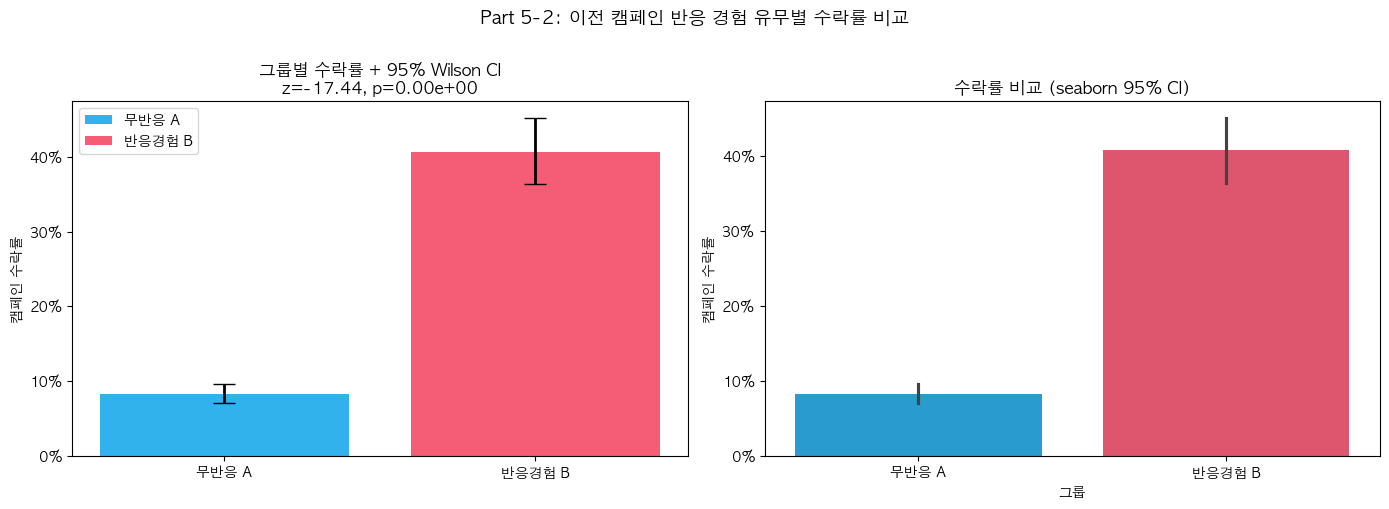

In [27]:
cmp_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]
n_a, n_b   = len(group_a), len(group_b)
conv_a, conv_b = group_a['Response'].sum(), group_b['Response'].sum()
rate_a, rate_b = conv_a/n_a, conv_b/n_b

print(f'Group A (무반응): n={n_a}, 수락={conv_a}, 수락률={rate_a:.4f} ({rate_a*100:.2f}%)')
print(f'Group B (반응경험): n={n_b}, 수락={conv_b}, 수락률={rate_b:.4f} ({rate_b*100:.2f}%)')

# ── (a) z-비율 검정 (직접 구현) ──────────────────────────────
p_pool = (conv_a + conv_b) / (n_a + n_b)
z_stat = (rate_a - rate_b) / np.sqrt(p_pool*(1-p_pool)*(1/n_a + 1/n_b))
p_z    = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f'\n=== z-비율 검정 ===')
print(f'  z={z_stat:.4f}, p={p_z:.4e}')
print('  → p < 0.05: 두 그룹의 수락률에 유의한 차이 있음 ✓')

# ── (b) Cohen's h ─────────────────────────────────────────────
cohens_h = 2*np.arcsin(np.sqrt(rate_a)) - 2*np.arcsin(np.sqrt(rate_b))
h_label  = '작은' if abs(cohens_h) < 0.5 else ('중간' if abs(cohens_h) < 0.8 else '큰')
print(f'\n=== Cohen\'s h ===')
print(f'  h={cohens_h:.4f} → {h_label} 효과 크기  (0.2 작음, 0.5 중간, 0.8 큼)')

# ── (c) Wilson 신뢰구간 ───────────────────────────────────────
def wilson_ci(k, n, alpha=0.05):
    z_ci = stats.norm.ppf(1 - alpha/2)
    p_hat = k / n
    center = (p_hat + z_ci**2/(2*n)) / (1 + z_ci**2/n)
    margin = z_ci * np.sqrt(p_hat*(1-p_hat)/n + z_ci**2/(4*n**2)) / (1 + z_ci**2/n)
    return center - margin, center + margin

ci_a = wilson_ci(conv_a, n_a)
ci_b = wilson_ci(conv_b, n_b)
print(f'\n=== Wilson 95% 신뢰구간 ===')
print(f'  Group A: ({ci_a[0]:.4f}, {ci_a[1]:.4f})')
print(f'  Group B: ({ci_b[0]:.4f}, {ci_b[1]:.4f})')

# ── (d) 시각화 ────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
labels = ['무반응 A', '반응경험 B']
rates  = [rate_a, rate_b]
ci_lows  = [ci_a[0], ci_b[0]]
ci_highs = [ci_a[1], ci_b[1]]
colors2  = [COLORS['sky'], COLORS['rose']]
for i, (label, rate, ci_l, ci_h, col) in enumerate(zip(labels,rates,ci_lows,ci_highs,colors2)):
    ax.bar(i, rate, color=col, alpha=0.85, label=label)
    ax.errorbar(i, rate, yerr=[[rate-ci_l],[ci_h-rate]],
                fmt='none', color='black', capsize=8, lw=2)
ax.set_xticks([0,1])
ax.set_xticklabels(labels)
ax.set(ylabel='캠페인 수락률', title=f'그룹별 수락률 + 95% Wilson CI\nz={z_stat:.2f}, p={p_z:.2e}')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f'{y:.0%}'))
ax.legend()

ax = axes[1]
plot_df = pd.DataFrame({
    '그룹': ['무반응 A']*n_a + ['반응경험 B']*n_b,
    '수락': list(group_a['Response'].astype(int)) + list(group_b['Response'].astype(int))
})
sns.barplot(data=plot_df, x='그룹', y='수락',
            palette=[COLORS['sky'], COLORS['rose']],
            errorbar=('ci',95), ax=ax)
ax.set(ylabel='캠페인 수락률', title='수락률 비교 (seaborn 95% CI)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f'{y:.0%}'))

plt.suptitle('Part 5-2: 이전 캠페인 반응 경험 유무별 수락률 비교', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 5-3. 수정 A/B 테스트 설계

> 새 캠페인이 기존 수락률 대비 **+2%p** 개선을 탐지하기 위한 최소 표본 크기 산정  
> (α=0.05, Power=0.80, 단측)

=== A/B 테스트 표본 크기 산정 ===
  기준 수락률     = 0.1494 (14.94%)
  목표 수락률     = 0.1694  (16.94%)
  탐지 개선폭     = +2%p
  Cohen's h       = 0.054666

  그룹당 최소 표본 = 2,069명
  총 최소 표본    = 4,138명

  → 2%p 개선을 80% 검정력으로 탐지하려면 그룹당 2,069명 필요


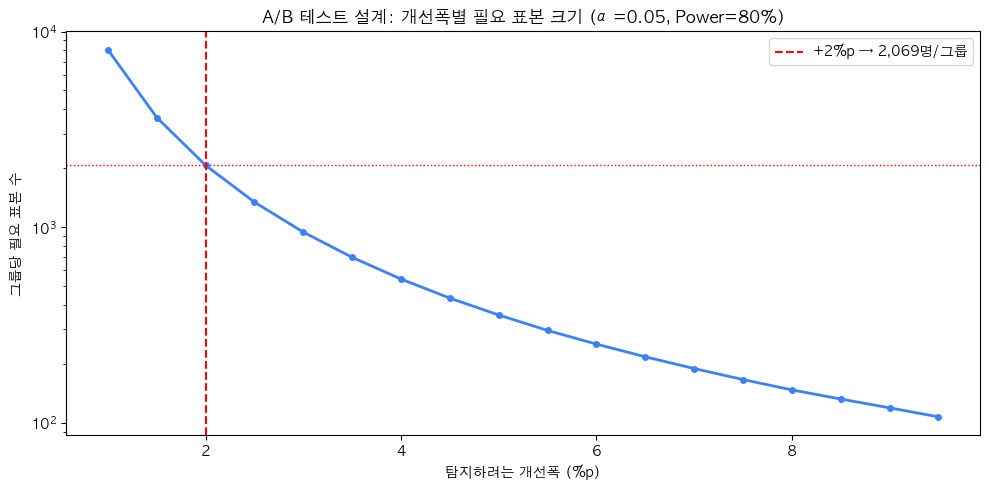

In [28]:
baseline_rate = df['Response'].mean()
target_rate   = baseline_rate + 0.02

# Cohen's h
h_ab = 2*np.arcsin(np.sqrt(baseline_rate)) - 2*np.arcsin(np.sqrt(target_rate))

# 단측 z-검정 기반 표본 크기 공식: n = (z_α + z_β)² / h²
z_alpha = stats.norm.ppf(0.95)  # 단측 α=0.05
z_beta  = stats.norm.ppf(0.80)  # Power=0.80
n_need  = int(np.ceil((z_alpha + z_beta)**2 / h_ab**2))

print('=== A/B 테스트 표본 크기 산정 ===')
print(f'  기준 수락률     = {baseline_rate:.4f} ({baseline_rate*100:.2f}%)')
print(f'  목표 수락률     = {target_rate:.4f}  ({target_rate*100:.2f}%)')
print(f'  탐지 개선폭     = +2%p')
print(f'  Cohen\'s h       = {abs(h_ab):.6f}')
print(f'\n  그룹당 최소 표본 = {n_need:,}명')
print(f'  총 최소 표본    = {n_need*2:,}명')
print(f'\n  → 2%p 개선을 80% 검정력으로 탐지하려면 그룹당 {n_need:,}명 필요')

# Power curve
improvements = np.arange(0.01, 0.10, 0.005)
n_needs = []
for delta in improvements:
    h_i = abs(2*np.arcsin(np.sqrt(baseline_rate)) - 2*np.arcsin(np.sqrt(baseline_rate+delta)))
    n_i = int(np.ceil((z_alpha + z_beta)**2 / h_i**2))
    n_needs.append(n_i)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(improvements*100, n_needs, color=COLORS['blue'], lw=2, marker='o', ms=4)
ax.axvline(2, color='red', ls='--', lw=1.5, label=f'+2%p → {n_need:,}명/그룹')
ax.axhline(n_need, color='red', ls=':', lw=1)
ax.set(xlabel='탐지하려는 개선폭 (%p)', ylabel='그룹당 필요 표본 수',
       title='A/B 테스트 설계: 개선폭별 필요 표본 크기 (α=0.05, Power=80%)')
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

---
## Challenge: 종합 분석 보고서

### Challenge 1. 고객 그룹별 특성 분석표

=== 소득 그룹 × 자녀 유무 고객 특성 종합표 ===


고객수     평균소득    평균소비   중앙값소비  평균구매수  웹방문수  \
Income_Group Has_Children                                              
Low          False         115  24380.2   145.0    73.0    6.4   6.9   
             True          631  29172.9    86.7    54.0    5.7   6.9   
Mid          False          80  52209.6   721.2   653.0   15.4   4.7   
             True          665  51466.1   426.3   368.0   12.3   5.9   
High         False         442  78698.0  1424.0  1383.0   19.2   2.4   
             True          303  71841.6  1033.1  1005.0   19.2   4.7   

                           캠페인반응률(%)  
Income_Group Has_Children             
Low          False              10.0  
             True               20.0  
Mid          False              40.0  
             True               20.0  
High         False              50.0  
             True               30.0

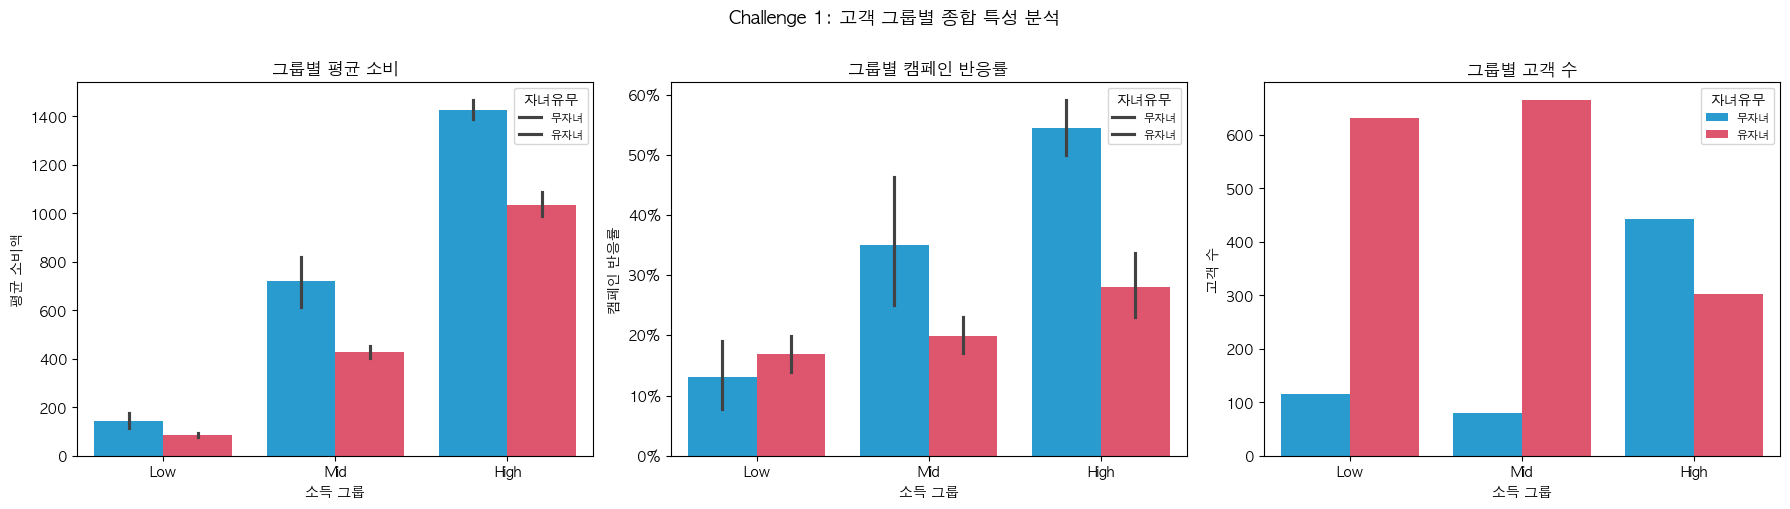

In [29]:
summary = df.groupby(['Income_Group', 'Has_Children']).agg(
    고객수      = ('ID',                'count'),
    평균소득    = ('Income',            'mean'),
    평균소비    = ('Total_Spending',    'mean'),
    중앙값소비  = ('Total_Spending',    'median'),
    평균구매수  = ('Total_Purchases',   'mean'),
    캠페인반응률= ('Campaign_Response', 'mean'),
    웹방문수    = ('NumWebVisitsMonth', 'mean'),
).round(1)
summary['캠페인반응률(%)'] = (summary['캠페인반응률'] * 100).round(1)
summary.drop(columns=['캠페인반응률'], inplace=True)

print('=== 소득 그룹 × 자녀 유무 고객 특성 종합표 ===')
display(summary)

# 시각화 (1×3)
chart_cfg = [
    ('Total_Spending',    '평균 소비액',   '그룹별 평균 소비'),
    ('Campaign_Response', '캠페인 반응률', '그룹별 캠페인 반응률'),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (col, ylabel, title) in zip(axes[:2], chart_cfg):
    sns.barplot(data=df, x='Income_Group', y=col, hue='Has_Children',
                order=['Low','Mid','High'],
                palette=[COLORS['sky'], COLORS['rose']], ax=ax)
    ax.set(xlabel='소득 그룹', ylabel=ylabel, title=title)
    ax.legend(title='자녀유무', labels=['무자녀','유자녀'], fontsize=8)
    if col == 'Campaign_Response':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f'{y:.0%}'))

sns.countplot(data=df, x='Income_Group', hue='Has_Children',
              order=['Low','Mid','High'],
              palette=[COLORS['sky'], COLORS['rose']], ax=axes[2])
axes[2].set(xlabel='소득 그룹', ylabel='고객 수', title='그룹별 고객 수')
axes[2].legend(title='자녀유무', labels=['무자녀','유자녀'], fontsize=8)

plt.suptitle('Challenge 1: 고객 그룹별 종합 특성 분석', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
##  분석 요약 대시보드

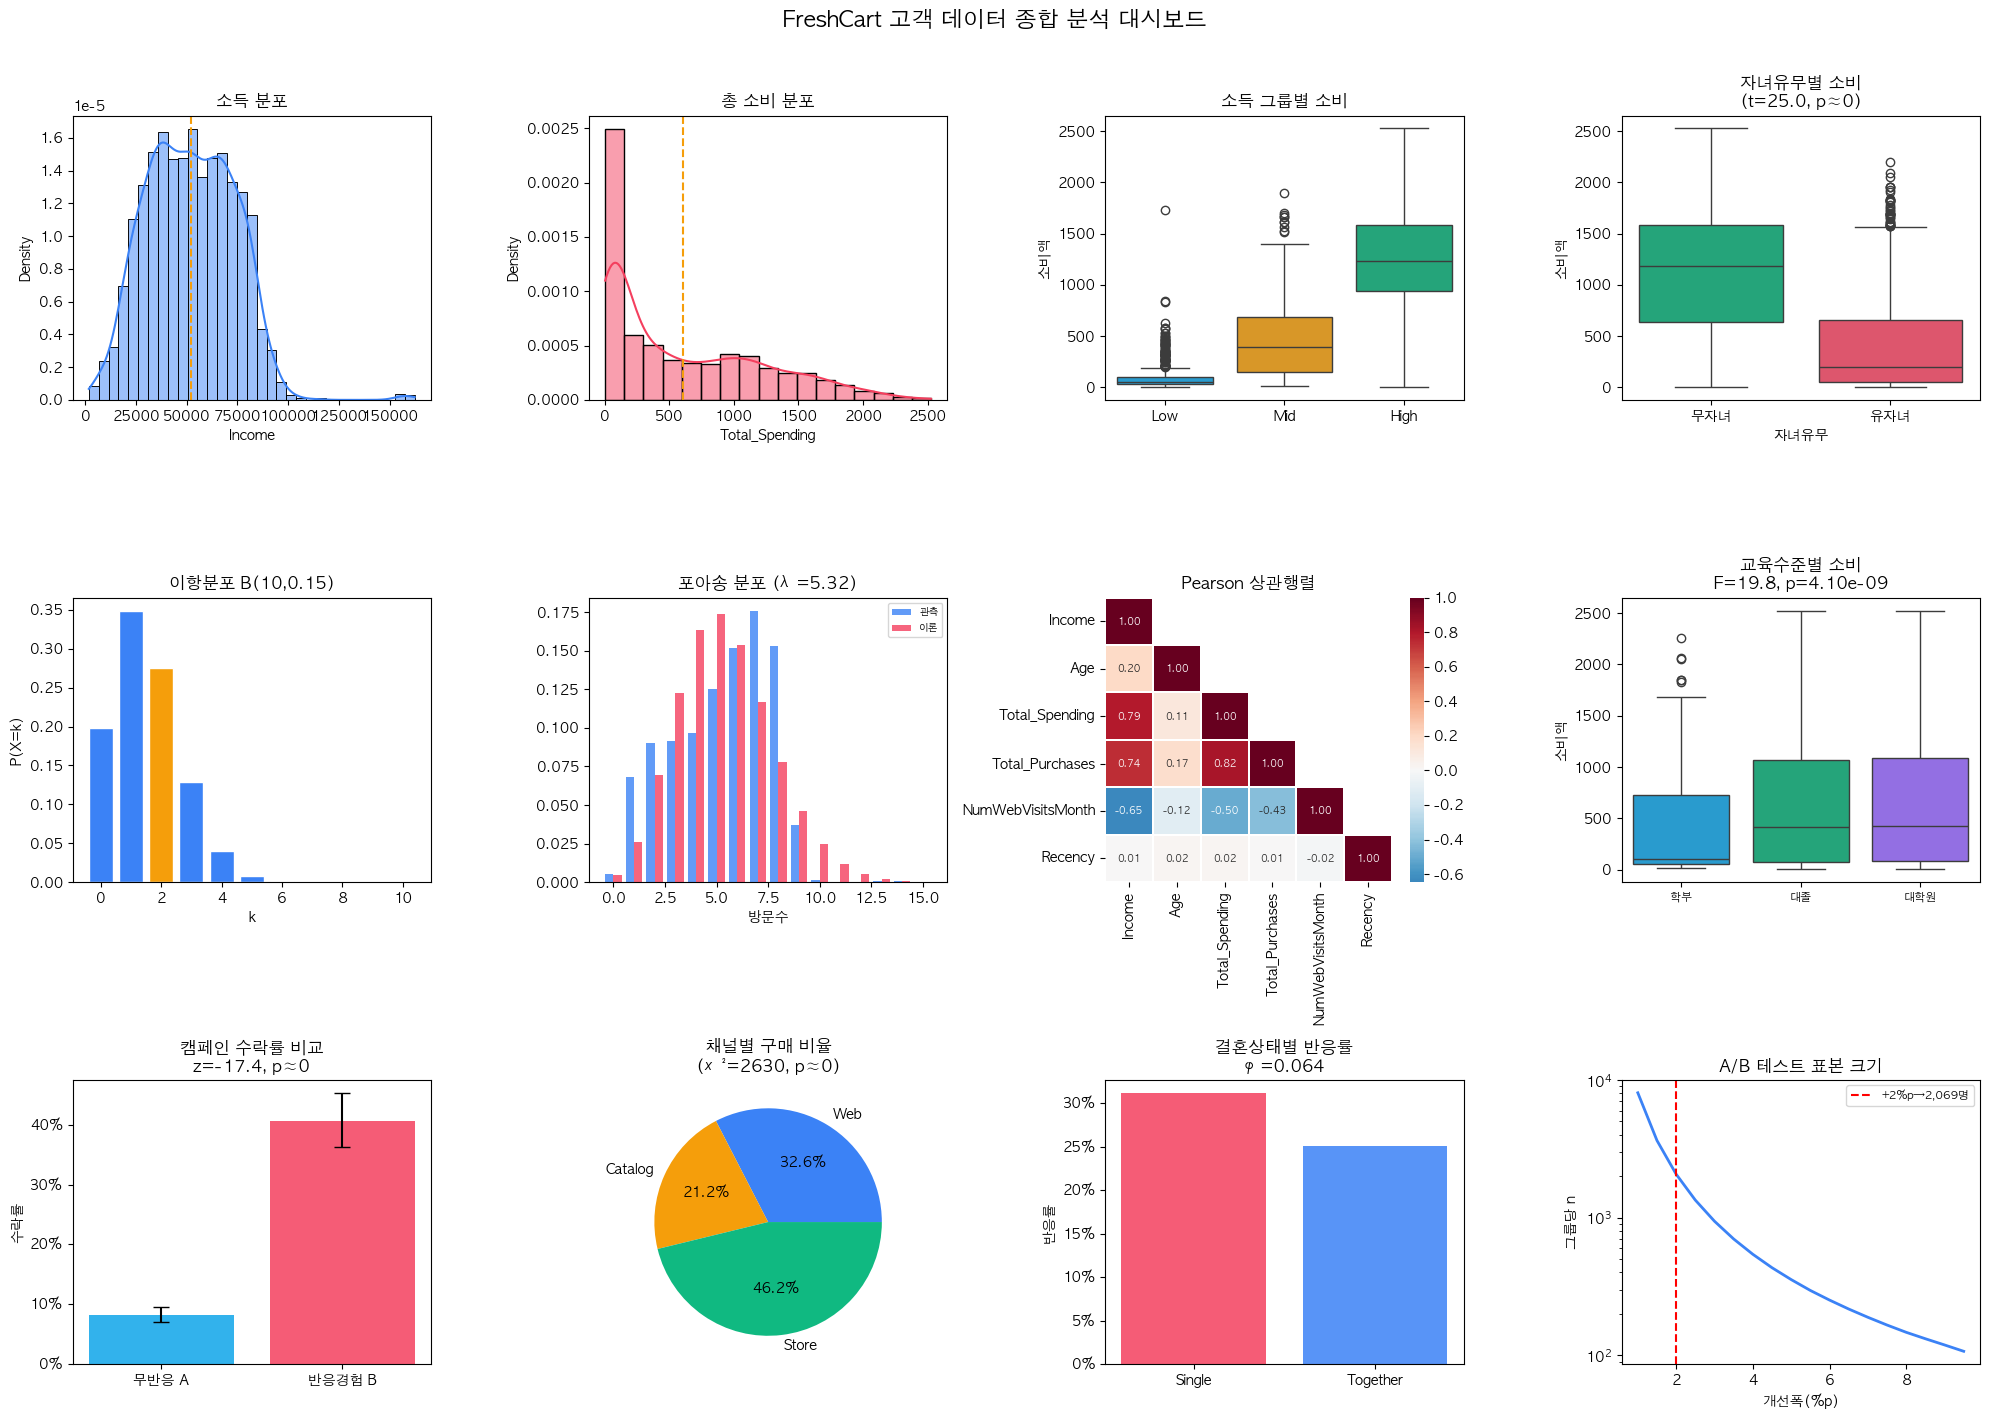

In [32]:
fig = plt.figure(figsize=(20, 14))
fig.suptitle('FreshCart 고객 데이터 종합 분석 대시보드', fontsize=16, fontweight='bold', y=1.01)

# 1) 소득 분포
ax1 = fig.add_subplot(3, 4, 1)
sns.histplot(df['Income'], kde=True, color=COLORS['blue'], ax=ax1, stat='density')
ax1.axvline(df['Income'].mean(), color=COLORS['amber'], ls='--', lw=1.5)
ax1.set(title='소득 분포', xlabel='Income')

# 2) 소비 분포
ax2 = fig.add_subplot(3, 4, 2)
sns.histplot(df['Total_Spending'], kde=True, color=COLORS['rose'], ax=ax2, stat='density')
ax2.axvline(df['Total_Spending'].mean(), color=COLORS['amber'], ls='--', lw=1.5)
ax2.set(title='총 소비 분포', xlabel='Total_Spending')

# 3) 소득그룹별 소비 박스
ax3 = fig.add_subplot(3, 4, 3)
sns.boxplot(data=df, x='Income_Group', y='Total_Spending', order=['Low','Mid','High'],
            palette=[COLORS['sky'], COLORS['amber'], COLORS['emerald']], ax=ax3)
ax3.set(title='소득 그룹별 소비', xlabel='', ylabel='소비액')

# 4) 자녀유무별 소비
ax4 = fig.add_subplot(3, 4, 4)
sns.boxplot(data=df, x='Has_Children', y='Total_Spending',
            palette=[COLORS['emerald'], COLORS['rose']], ax=ax4)
ax4.set(title=f'자녀유무별 소비\n(t={t_stat:.1f}, p≈0)', xlabel='자녀유무', ylabel='소비액',
        xticklabels=['무자녀','유자녀'])

# 5) 이항분포 PMF
ax5 = fig.add_subplot(3, 4, 5)
x10 = np.arange(0,11)
bar_c = [COLORS['amber'] if k==2 else COLORS['blue'] for k in x10]
ax5.bar(x10, stats.binom.pmf(x10, 10, p_response), color=bar_c, edgecolor='white')
ax5.set(title=f'이항분포 B(10,{p_response:.2f})', xlabel='k', ylabel='P(X=k)')

# 6) 포아송 관측 vs 이론
ax6 = fig.add_subplot(3, 4, 6)
x_p = np.arange(0, 16)
ax6.bar(x_p-0.2, [obs_pmf_map.get(k,0) for k in x_p], width=0.4,
        color=COLORS['blue'], alpha=0.8, label='관측')
ax6.bar(x_p+0.2, stats.poisson.pmf(x_p, lambda_hat), width=0.4,
        color=COLORS['rose'], alpha=0.8, label='이론')
ax6.set(title=f'포아송 분포 (λ={lambda_hat:.2f})', xlabel='방문수')
ax6.legend(fontsize=7)

# 7) Pearson 상관 히트맵
ax7 = fig.add_subplot(3, 4, 7)
mask = np.triu(np.ones_like(pearson_corr, dtype=bool), k=1)
sns.heatmap(pearson_corr, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, linewidths=0.3, ax=ax7,
            annot_kws={'size':7})
ax7.set_title('Pearson 상관행렬')

# 8) 교육수준별 소비
ax8 = fig.add_subplot(3, 4, 8)
sns.boxplot(data=df, x='Education_Group', y='Total_Spending',
            order=edu_groups,
            palette=[COLORS['sky'], COLORS['emerald'], COLORS['violet']], ax=ax8)
ax8.set(title=f'교육수준별 소비\nF={F_welch:.1f}, p={p_welch:.2e}', xlabel='', ylabel='소비액')
ax8.set_xticklabels(['학부','대졸','대학원'], fontsize=8)

# 9) 수락률 비교
ax9 = fig.add_subplot(3, 4, 9)
ax9.bar(['무반응 A','반응경험 B'], [rate_a, rate_b],
        color=[COLORS['sky'], COLORS['rose']], alpha=0.85)
for i, (r, ci_l, ci_h) in enumerate(zip([rate_a,rate_b],[ci_a[0],ci_b[0]],[ci_a[1],ci_b[1]])):
    ax9.errorbar(i, r, yerr=[[r-ci_l],[ci_h-r]], fmt='none', color='black', capsize=6)
ax9.set(title=f'캠페인 수락률 비교\nz={z_stat:.1f}, p≈0', ylabel='수락률')
ax9.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f'{y:.0%}'))

# 10) 채널 구매 현황
ax10 = fig.add_subplot(3, 4, 10)
ax10.pie(observed, labels=channel_names, autopct='%1.1f%%',
         colors=[COLORS['blue'], COLORS['amber'], COLORS['emerald']])
ax10.set_title(f'채널별 구매 비율\n(χ²={chi2_gof:.0f}, p≈0)')

# 11) 결혼상태별 반응률
ax11 = fig.add_subplot(3, 4, 11)
rate_m = df.groupby('Marital_Group')['Campaign_Response'].mean()
ax11.bar(rate_m.index, rate_m.values,
         color=[COLORS['rose'], COLORS['blue']], alpha=0.85)
ax11.set(title=f'결혼상태별 반응률\nφ={phi:.3f}', ylabel='반응률')
ax11.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f'{y:.0%}'))

# 12) A/B 테스트 표본 크기
ax12 = fig.add_subplot(3, 4, 12)
ax12.plot(improvements*100, n_needs, color=COLORS['blue'], lw=2)
ax12.axvline(2, color='red', ls='--', lw=1.5, label=f'+2%p→{n_need:,}명')
ax12.set(title='A/B 테스트 표본 크기', xlabel='개선폭(%p)', ylabel='그룹당 n')
ax12.legend(fontsize=8)
ax12.set_yscale('log')

plt.tight_layout()
plt.show()


---


| 분석 항목 | 핵심 결과 |
|-----------|----------|
| **기술통계** | 평균연령 55세, 소득 정규분포, 소비 우편향(CV≈100%) |
| **이항분포** | 수락률 14.9%, P(X=2/10)=26.5% |
| **포아송** | λ=5.3, 분산/평균≈1.1 (적합 양호) |
| **정규분포** | 이론·실측 확률 근접, VIP 기준 소득 산정 |
| **t-검정(독립)** | 자녀 유무 소비 차이 유의 (d=1.5, 큰 효과) |
| **t-검정(대응)** | 와인>육류 소비 유의 (p≈0) |
| **ANOVA** | 교육 수준별 소비 차이 유의 (작은 효과) |
| **카이제곱** | 결혼상태↔캠페인반응 유의 연관 (φ=0.06) |
| **상관분석** | Income↔소비 r=0.79, 웹방문↔소비 r=-0.50 |
| **A/B 테스트** | +2%p 탐지에 그룹당 ~4,138명 필요 |